In [76]:
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from lofo import LOFOImportance, plot_importance, Dataset
import lightgbm as lgbm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import optuna
from IPython.core.display import HTML
import dataframe_image as dfi
from sklearn.metrics import mutual_info_score
import seaborn as sns
# pd.options.display.float_format = '{:,.3f}'.format

In [77]:
train_in = pd.read_csv('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/data/application_train.csv')
test_in = pd.read_csv('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/data/application_test.csv')
print('Train set shape: ', train_in.shape)
print('Test set shape: ', test_in.shape)
train_in.columns = train_in.columns.str.lower()
test_in.columns = test_in.columns.str.lower()

Train set shape:  (307511, 122)
Test set shape:  (48744, 121)


In [78]:
print(train_in.columns)
print([x for x in train_in.columns if x not in test_in.columns])
d_types = train_in.dtypes

Index(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total',
       'amt_credit', 'amt_annuity',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=122)
['target']


In [79]:
# inspections.score.describe()
# def test_dependency(df, col1, col2):
#     '''Tests whether there is total redundancy betwen col1 and col2
#        by testing the number of unique combinations'''
#     unique_1 = len(df[col1].unique())
#     unique_2 = len(df[col2].unique())
#     unique_combos = len(df[[col1, col2]].drop_duplicates())
#     if unique_1 == 2 and unique_2 == 2:
#         if list(sorted(df[col1].unique())) == [0, 1] and unique_combos == max(unique_1, unique_2):
#             print("Unique combos of {} and {}: {}".format(col1, col2, unique_combos))

# for col1 in train_in.columns:
#     for col2 in train_in.columns:
#         if col2 == col1 or col1 in ['sk_id_curr', 'target'] or col2 in ['sk_id_curr', 'target']:
#             continue
#         test_dependency(train_in, col1, col2)

In [80]:
unique_cols = [i for i in train_in.columns if i not in test_in.columns]
unique_cols

['target']

In [81]:
# Test if these variables are a unique identifier
possible_identifier = ['sk_id_curr']
print("# of duplicates: ",sum(train_in.duplicated(possible_identifier)))

# of duplicates:  0


In [82]:
for col in train_in.columns:
    if len(train_in[col].unique()) > 10:
        temp = train_in.copy()
        temp['count'] = temp.groupby(col)['sk_id_curr'].transform('count')
        temp['percentage'] = temp['count'] / len(temp)
        if temp['percentage'].max() > 0.15:
            print('{}: {}, {:,}, {:.1%}'.format(col, temp[temp['percentage'] > 0.15].reset_index().loc[0][col], temp[temp['percentage'] > 0.15].reset_index().loc[0]['count'], temp[temp['percentage'] > 0.15].reset_index().loc[0]['percentage']))

cnt_children: 0, 215,371, 70.0%
days_employed: 365243, 55,374, 18.0%
occupation_type: Laborers, 55,186.0, 17.9%
cnt_fam_members: 1.0, 67,847.0, 22.1%
organization_type: Business Entity Type 3, 67,992, 22.1%
elevators_avg: 0.0, 85,718.0, 27.9%
floorsmax_avg: 0.1667, 61,875.0, 20.1%
nonlivingapartments_avg: 0.0, 54,549.0, 17.7%
nonlivingarea_avg: 0.0, 58,735.0, 19.1%
elevators_mode: 0.0, 89,498.0, 29.1%
floorsmax_mode: 0.1667, 65,550.0, 21.3%
nonlivingapartments_mode: 0.0, 59,255.0, 19.3%
nonlivingarea_mode: 0.0, 67,126.0, 21.8%
elevators_medi: 0.0, 87,026.0, 28.3%
floorsmax_medi: 0.1667, 63,607.0, 20.7%
nonlivingapartments_medi: 0.0, 56,097.0, 18.2%
nonlivingarea_medi: 0.0, 60,954.0, 19.8%
obs_30_cnt_social_circle: 1.0, 48,783.0, 15.9%
def_30_cnt_social_circle: 0.0, 271,324.0, 88.2%
obs_60_cnt_social_circle: 1.0, 48,870.0, 15.9%
amt_req_credit_bureau_mon: 0.0, 222,233.0, 72.3%
amt_req_credit_bureau_qrt: 0.0, 215,417.0, 70.1%
amt_req_credit_bureau_year: 1.0, 63,405.0, 20.6%


In [83]:
for col in train_in.columns:
    if 'XNA' in train_in[col].unique():
        print(col)

code_gender
organization_type


In [84]:
def compute_profile_metrics(data):
    
    metrics = pd.DataFrame()
    
    for col, index in zip(data.columns, range(0, len(data.columns))):
        if col == 'target':
            continue
        
        if col == 'days_employed':
            data[col] = np.where((data[col] == 365243), np.nan, data[col])
        
        if isinstance(data.reset_index().loc[0][col], str) or sorted(list(data[col].unique())) == [0, 1]:
            data[col] = np.where((data[col].isnull() == True) | (data[col] == 'XNA'), '', data[col])
            
            missing_perc = len(data[(data[col].isnull() == True) | (data[col] == '')]) / len(data)
            
            data[col] = np.where((data[col] == 'Yes'), 'Y', data[col])
            data[col] = np.where((data[col] == 'No'), 'N', data[col])
            
            if sorted(list(data[col].unique())) == ['0', '1'] or sorted(list(data[col].unique())) == ['', '0', '1']:
                data[col] = data[col].astype(float)
            
            dtype = data.dtypes[index].name
            num_vals = len(list(data[col].unique()))
            
            if sorted(list(data[col].unique())) == [0, 1] or sorted(list(data[col].unique())) == [0, 1, np.nan] or sorted(list(data[col].unique())) == ['N', 'Y'] or sorted(list(data[col].unique())) == ['', 'N', 'Y']:
                perc_yes = len(data[(data[col] == 'Y') | (data[col] == 1)]) / len(data)
                metrics = metrics.append({'column': col, 'dtype': dtype, 'perc_yes': perc_yes, 'unique_vals': num_vals, 'missing_perc': missing_perc}, ignore_index=True)
            else:
                metrics = metrics.append({'column': col, 'dtype': dtype, 'perc_yes': np.nan, 'unique_vals': num_vals, 'missing_perc': missing_perc}, ignore_index=True)
        else:
            median = data[col].median()
            mean = data[col].mean()
            min_val = data[col].min()
            max_val = data[col].max()
            dtype = data.dtypes[index].name
            num_vals = len(list(data[col].unique()))
            missing_perc = len(data[(data[col].isnull() == True) | (data[col] == '')]) / len(data)
            metrics = metrics.append({'column': col, 'dtype': dtype, 'median': median, 'mean': mean, 'min': min_val, 'max': max_val, 'unique_vals': num_vals, 'missing_perc': missing_perc}, ignore_index=True)
    
    return metrics, data

In [85]:
train = train_in.copy()
metrics, train = compute_profile_metrics(train)

In [14]:
ads_used = ['EXT_SOURCE_3',
             'EXT_SOURCE_2',
             'EXT_SOURCE_1',
             'NAME_EDUCATION_TYPE',
             'CODE_GENDER',
             'NAME_INCOME_TYPE',
             'ORGANIZATION_TYPE',
             'DAYS_EMPLOYED',
             'FLOORSMAX_AVG',
             'FLOORSMAX_MEDI',
             'FLOORSMAX_MODE',
             'EMERGENCYSTATE_MODE',
             'HOUSETYPE_MODE',
             'AMT_GOODS_PRICE',
             'REGION_POPULATION_RELATIVE',
             'OWN_CAR_AGE',
             'DAYS_REGISTRATION',
             'OCCUPATION_TYPE',
             'FLAG_DOCUMENT_3',
             'REG_CITY_NOT_LIVE_CITY',
             'FLAG_EMP_PHONE',
             'REG_CITY_NOT_WORK_CITY',
             'DAYS_ID_PUBLISH',
             'DAYS_LAST_PHONE_CHANGE',
             'REGION_RATING_CLIENT',
             'REGION_RATING_CLIENT_W_CITY',
             'DAYS_BIRTH']

ads_used_lower = [x.lower() for x in ads_used]
pd.options.display.max_rows = 150
metrics_all = metrics.copy()
metrics_used = metrics.copy()
for df, file_name in zip([metrics_all, metrics_used], ['metrics_all_profiled', 'metrics_used_profiled']):
    if 'used' in file_name:
        df = df[df['column'].isin(ads_used_lower)]
    for col in ['missing_perc', 'perc_yes']:
        df[col] = df[col].apply('{:.1%}'.format)
        df[col] = np.where((df[col] == 'nan%'), '', df[col])
    for col in ['median', 'mean', 'min', 'max']:
        df[col] = df[col].apply('{:,.1f}'.format)
    for col in ['unique_vals']:
        df[col] = df[col].astype(int)
        df[col] = df[col].apply('{:,}'.format)
    if 'all' in file_name:
        temp1 = df.copy()
        temp2 = df.copy()
        temp3 = df.copy()
        temp1 = temp1.loc[0:40]
        temp2 = temp2.loc[41:80]
        temp3 = temp3.loc[81:]
        for temp, file_name_temp in zip([temp1, temp2, temp3], ['_1', '_2', '_3']):
            dfi.export(temp.style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}{}.png'.format(file_name, file_name_temp), max_rows=150)
    else:
        dfi.export(df.style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}.png'.format(file_name), max_rows=150)
    if 'used' in file_name:
        display(df)

,column,dtype,median,mean,min,max,unique_vals,missing_perc,perc_yes
2,code_gender,object,nan,nan,nan,nan,3,0.0%,
9,amt_goods_price,float64,"450,000.0","538,396.2","40,500.0","4,050,000.0","1,003",0.1%,
11,name_income_type,object,nan,nan,nan,nan,8,0.0%,
12,name_education_type,object,nan,nan,nan,nan,5,0.0%,
15,region_population_relative,float64,0.0,0.0,0.0,0.1,81,0.0%,
16,days_birth,int64,"-15,750.0","-16,037.0","-25,229.0","-7,489.0","17,460",0.0%,
17,days_employed,float64,"-1,648.0","-2,384.2","-17,912.0",0.0,"12,574",18.0%,
18,days_registration,float64,"-4,504.0","-4,986.1","-24,672.0",0.0,"15,688",0.0%,
19,days_id_publish,int64,"-3,254.0","-2,994.2","-7,197.0",0.0,"6,168",0.0%,
20,own_car_age,float64,9.0,12.1,0.0,91.0,63,66.0%,


ext_source_3
ext_source_2
ext_source_1
name_education_type
code_gender
name_income_type
organization_type
days_employed
floorsmax_avg
floorsmax_medi
floorsmax_mode
emergencystate_mode
housetype_mode
amt_goods_price
region_population_relative
own_car_age
days_registration
occupation_type
flag_document_3
reg_city_not_live_city
flag_emp_phone
reg_city_not_work_city
days_id_publish
days_last_phone_change
region_rating_client
region_rating_client_w_city
days_birth


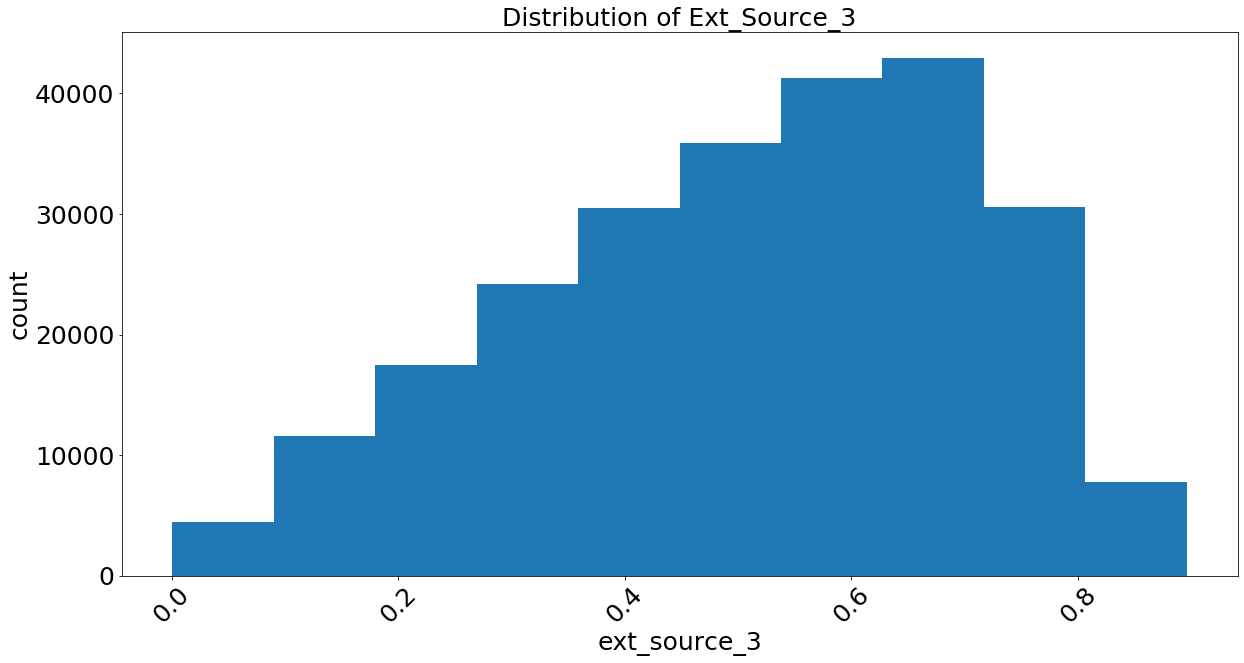

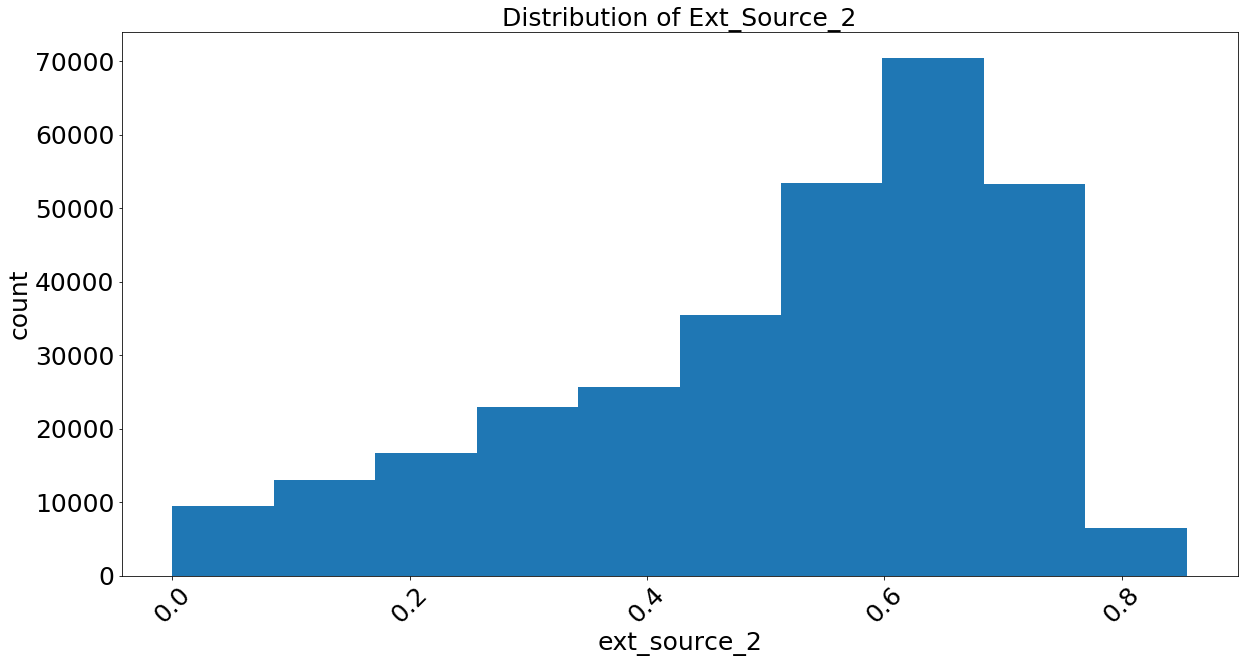

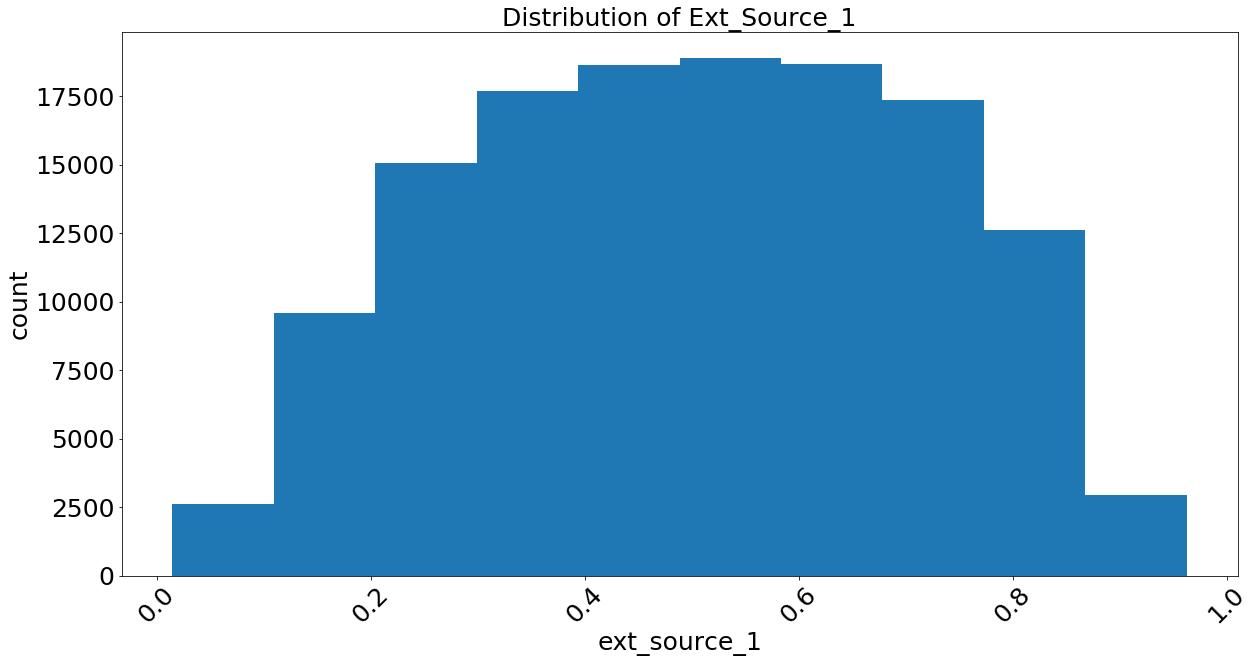

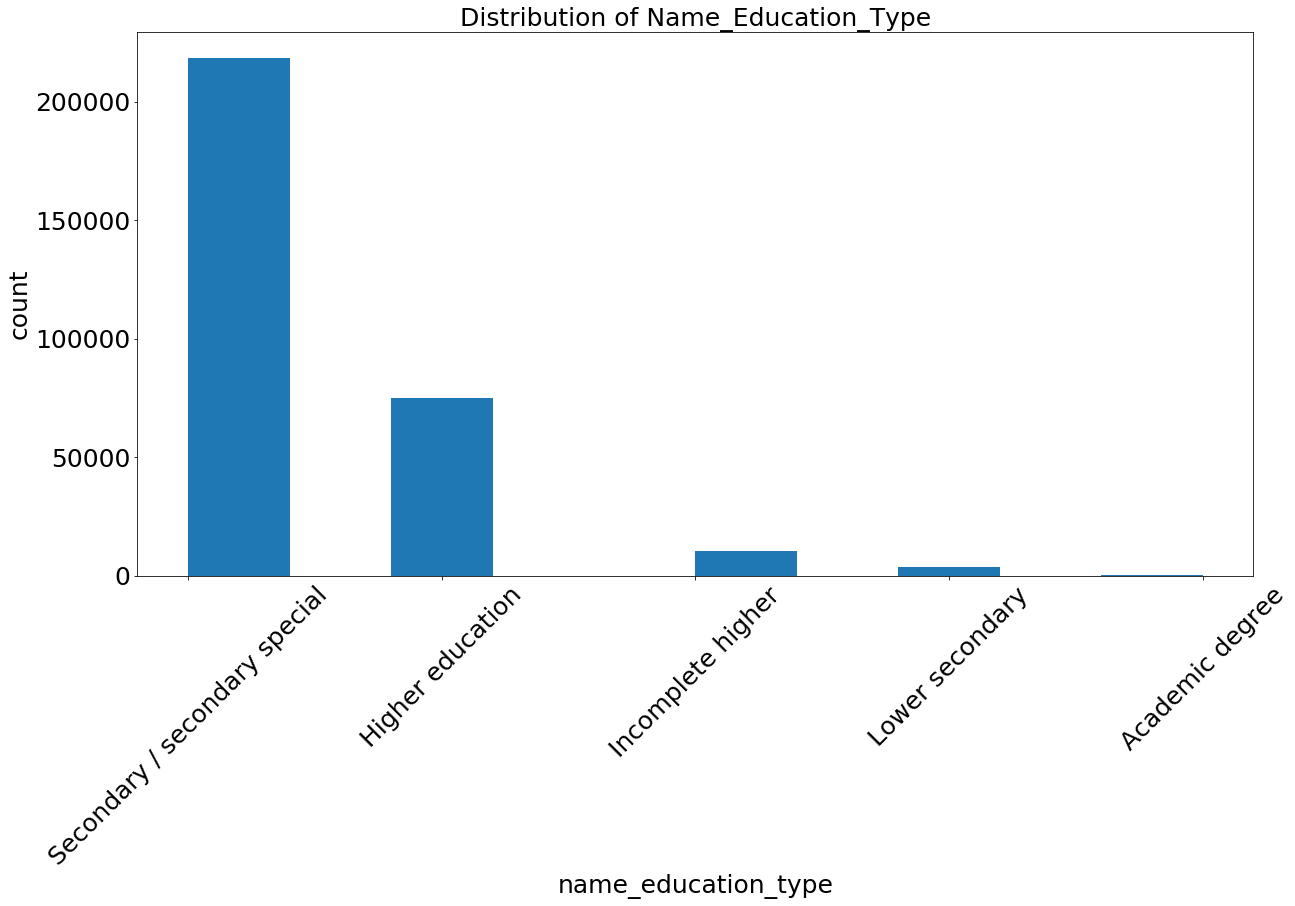

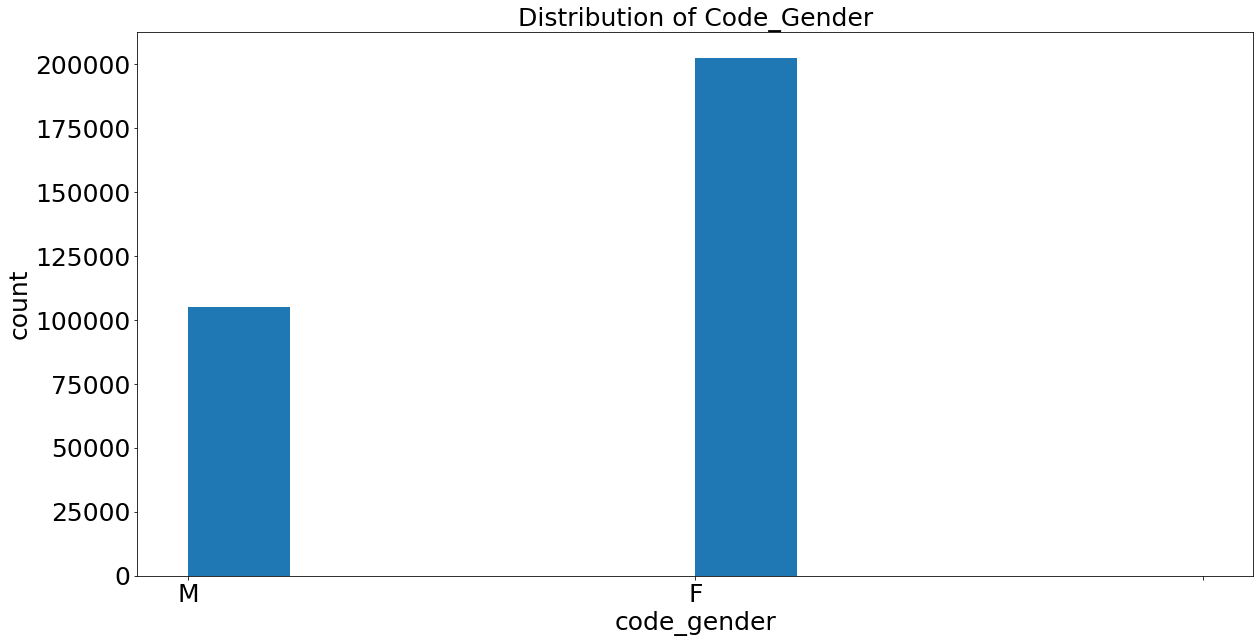

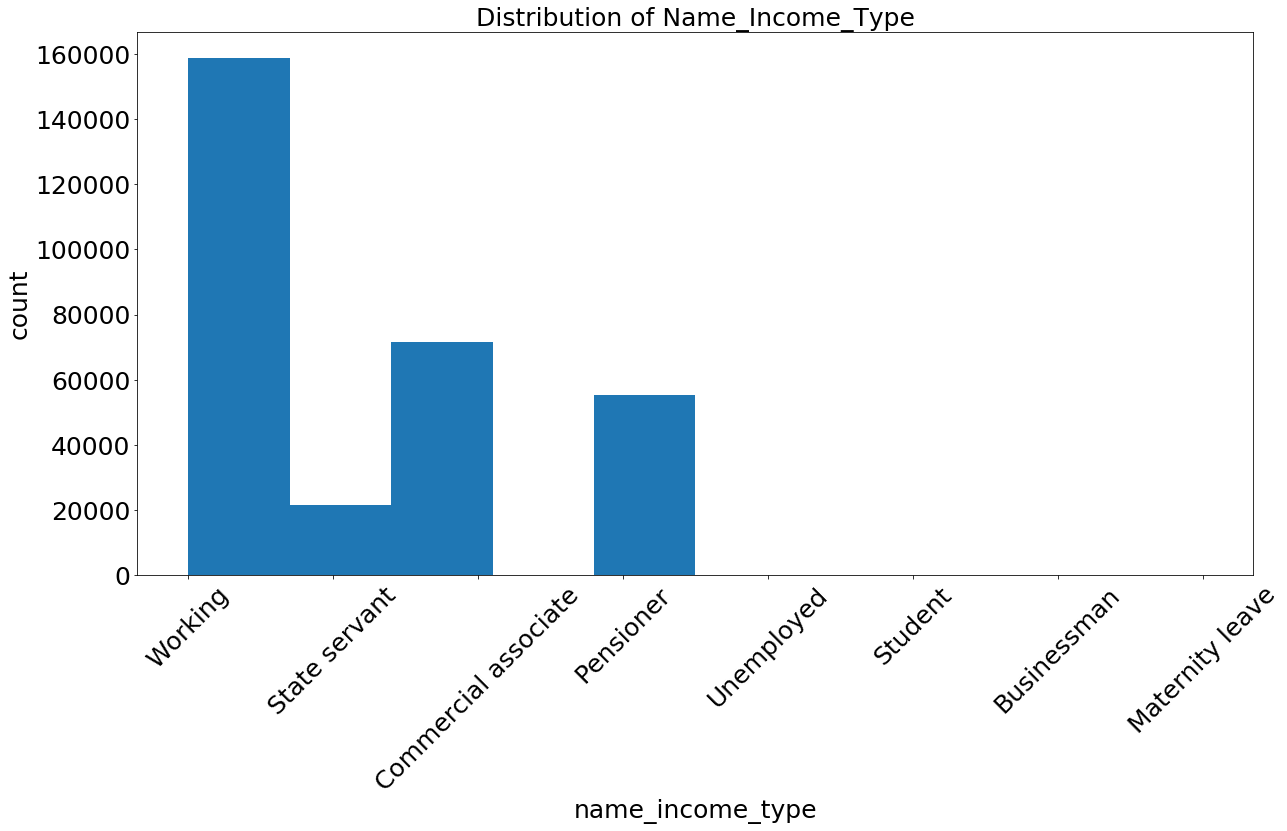

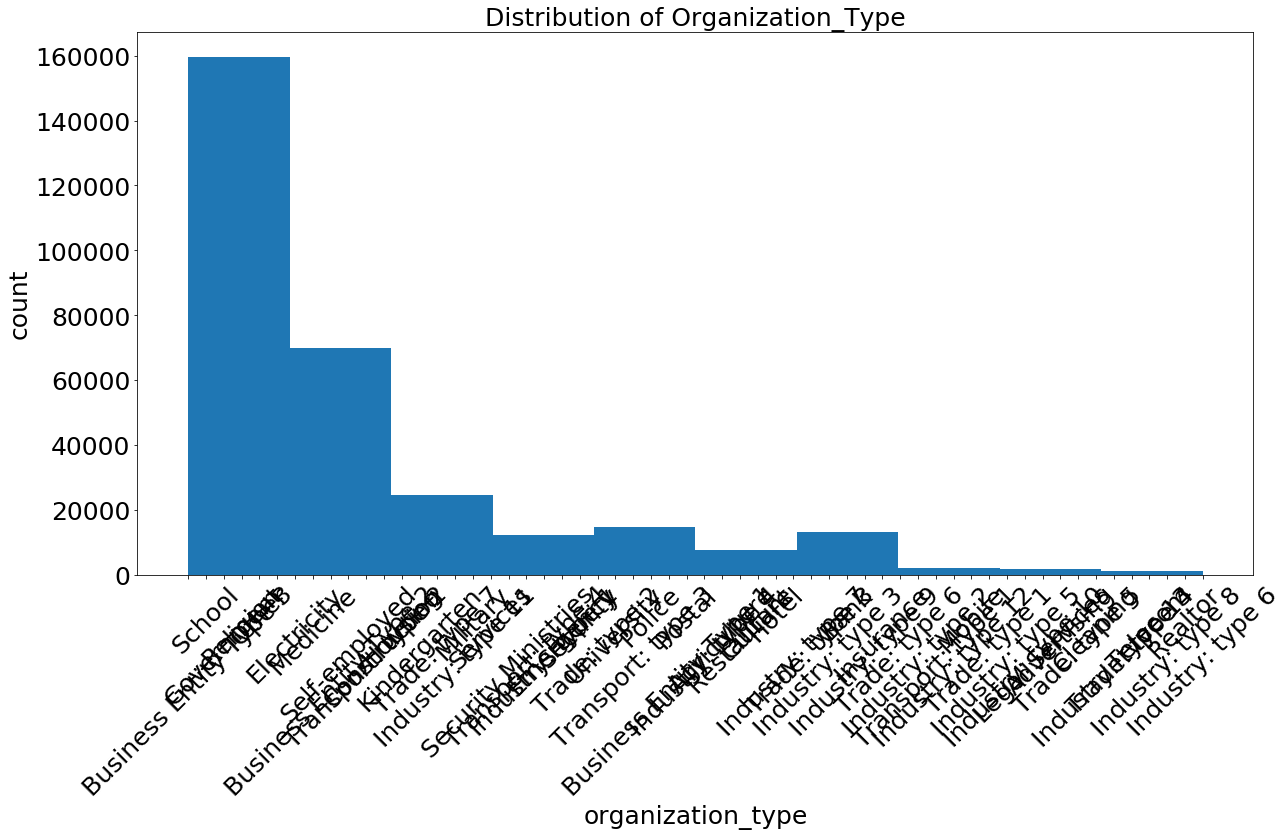

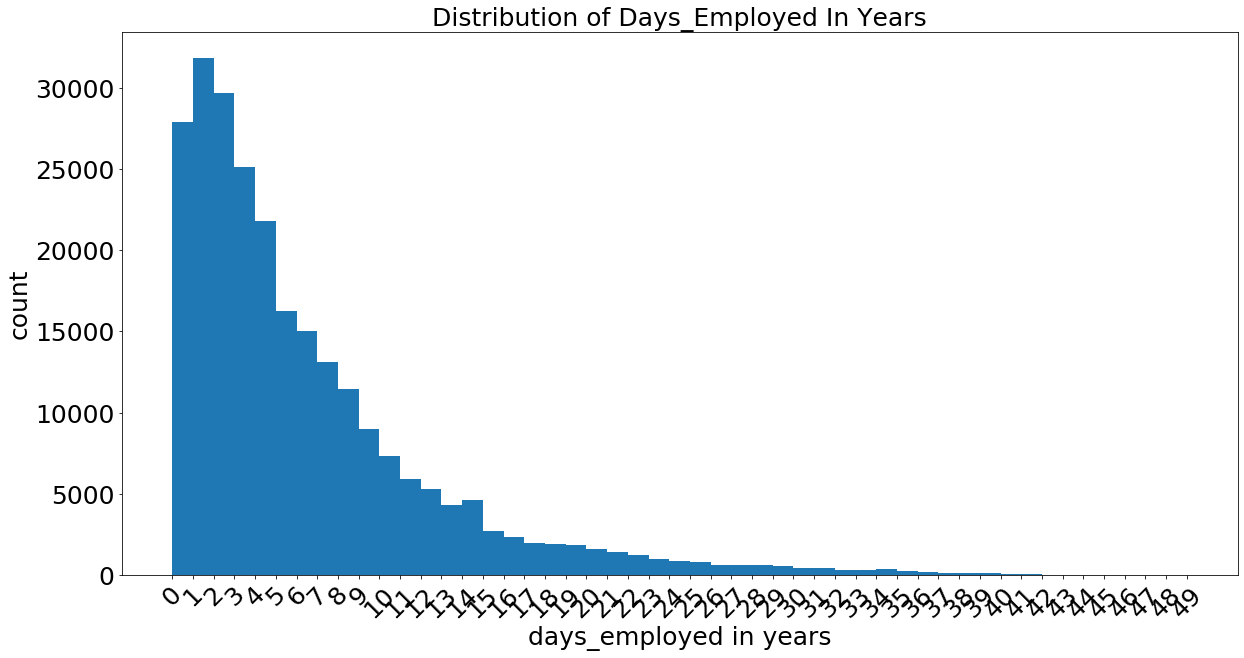

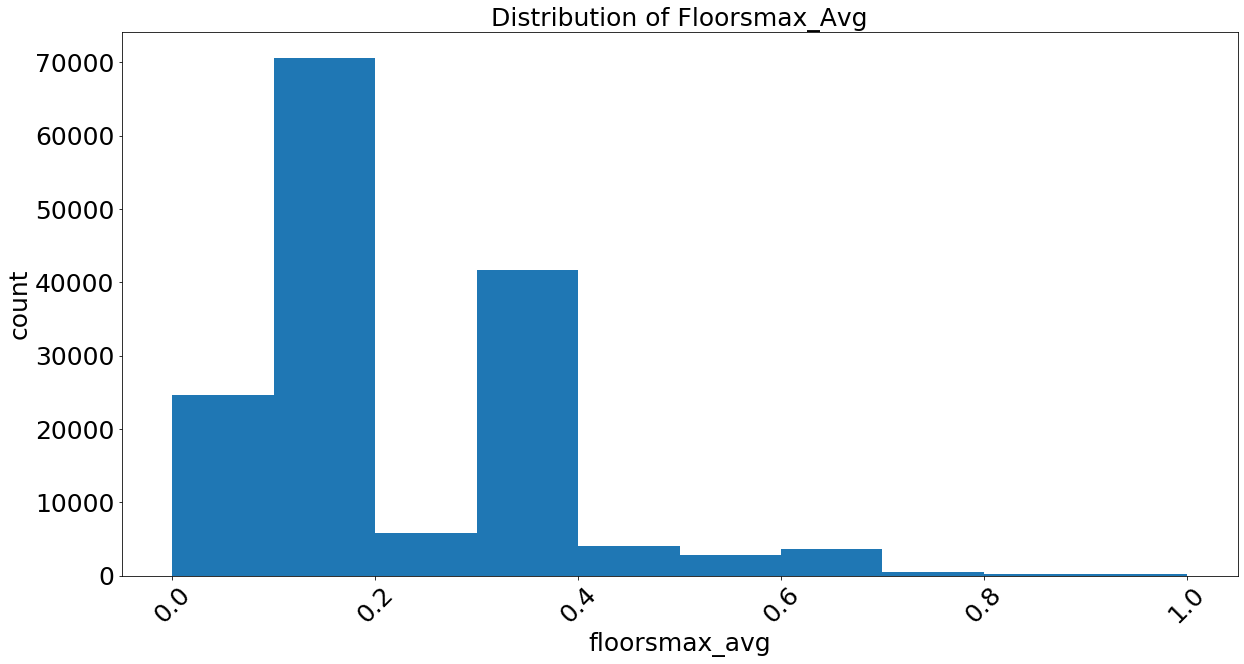

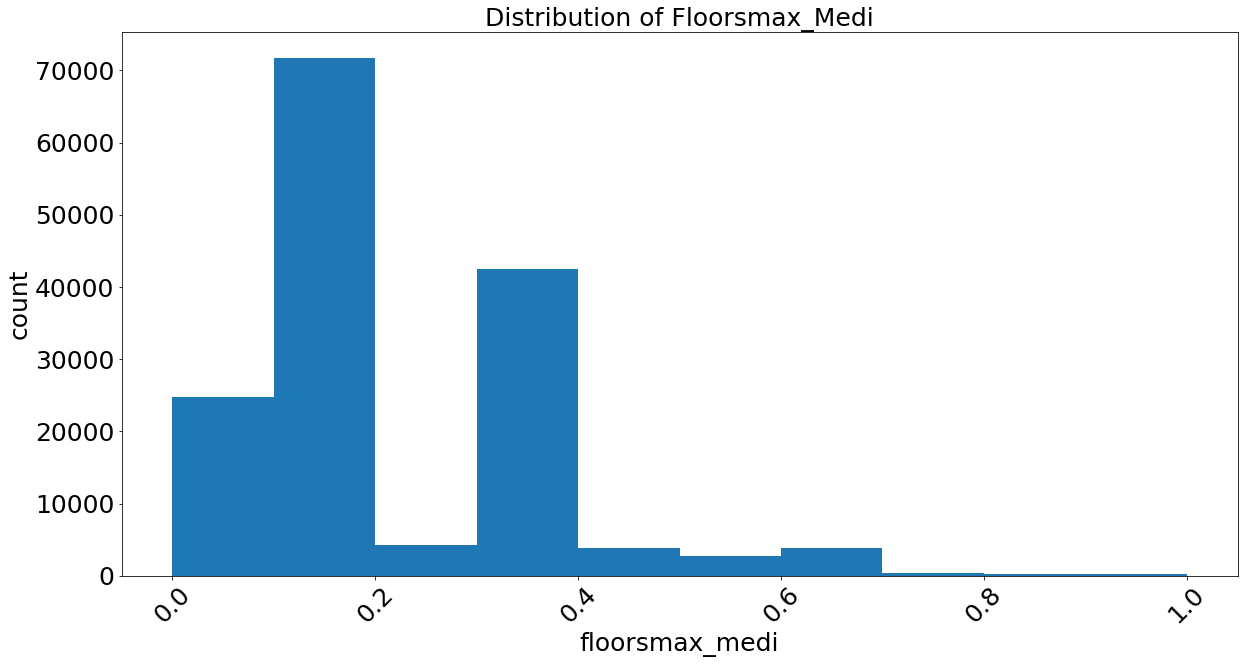

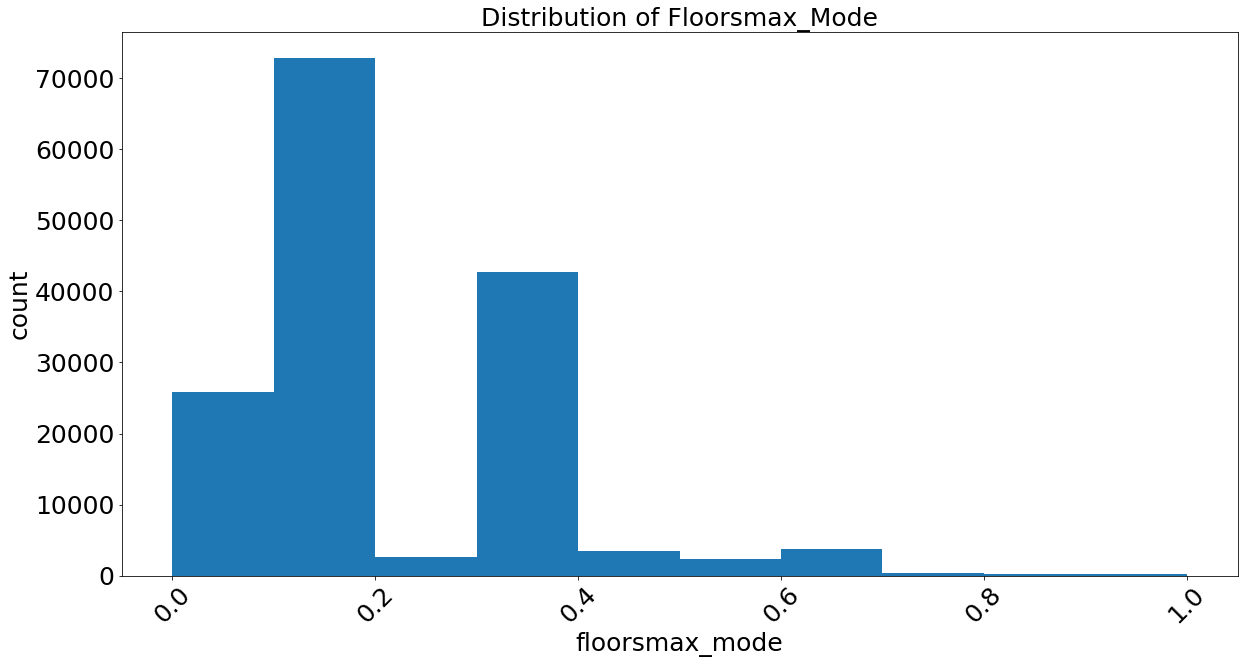

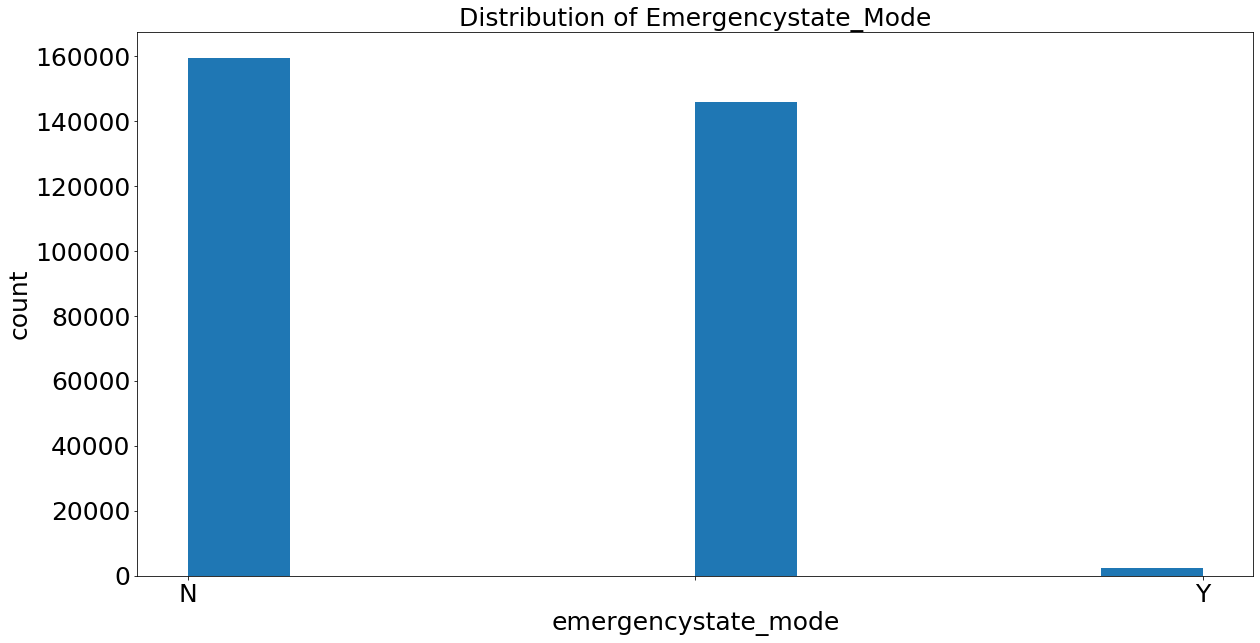

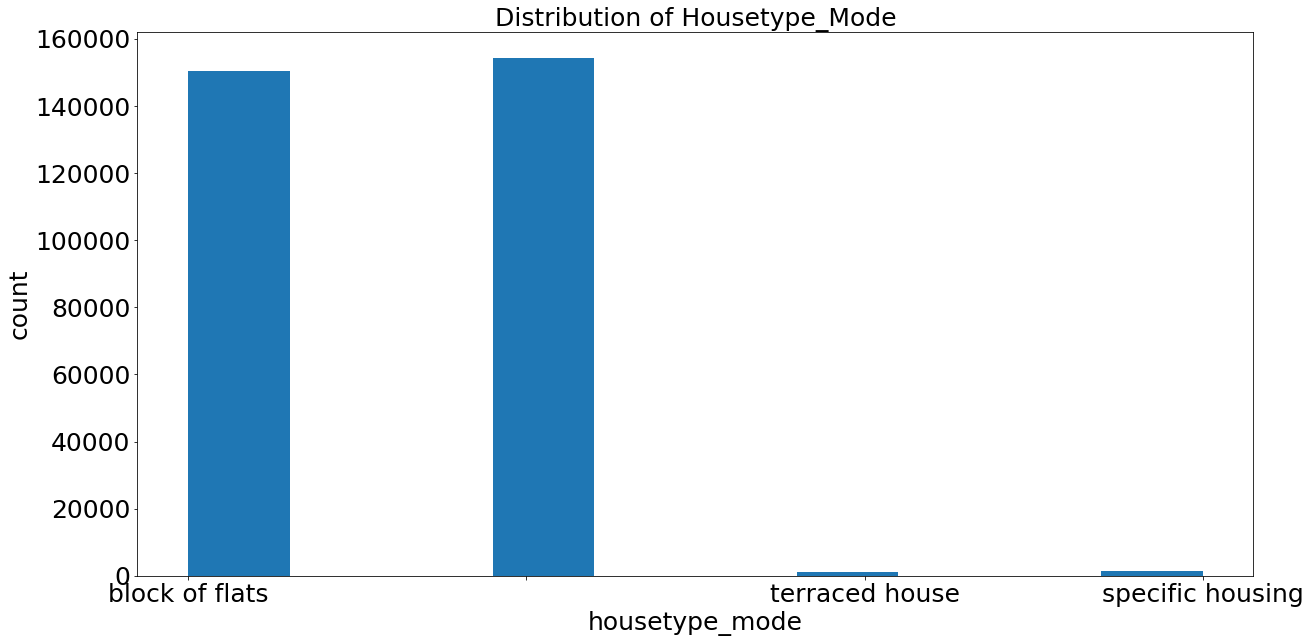

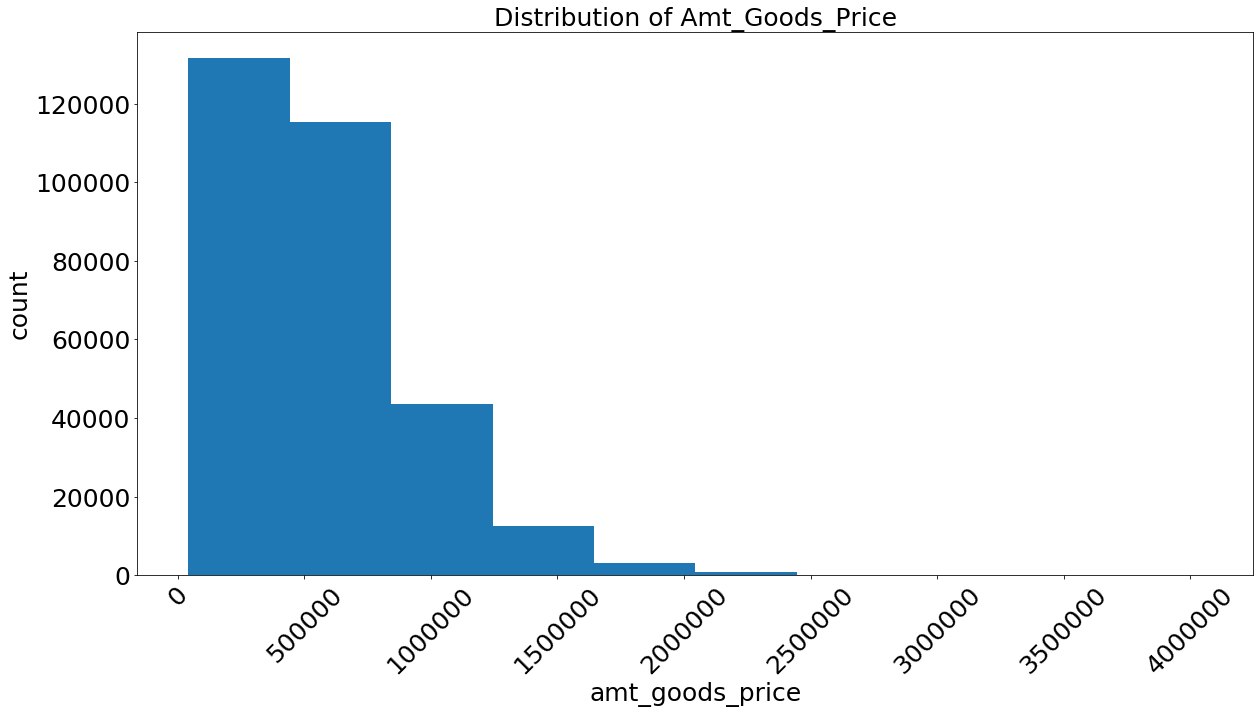

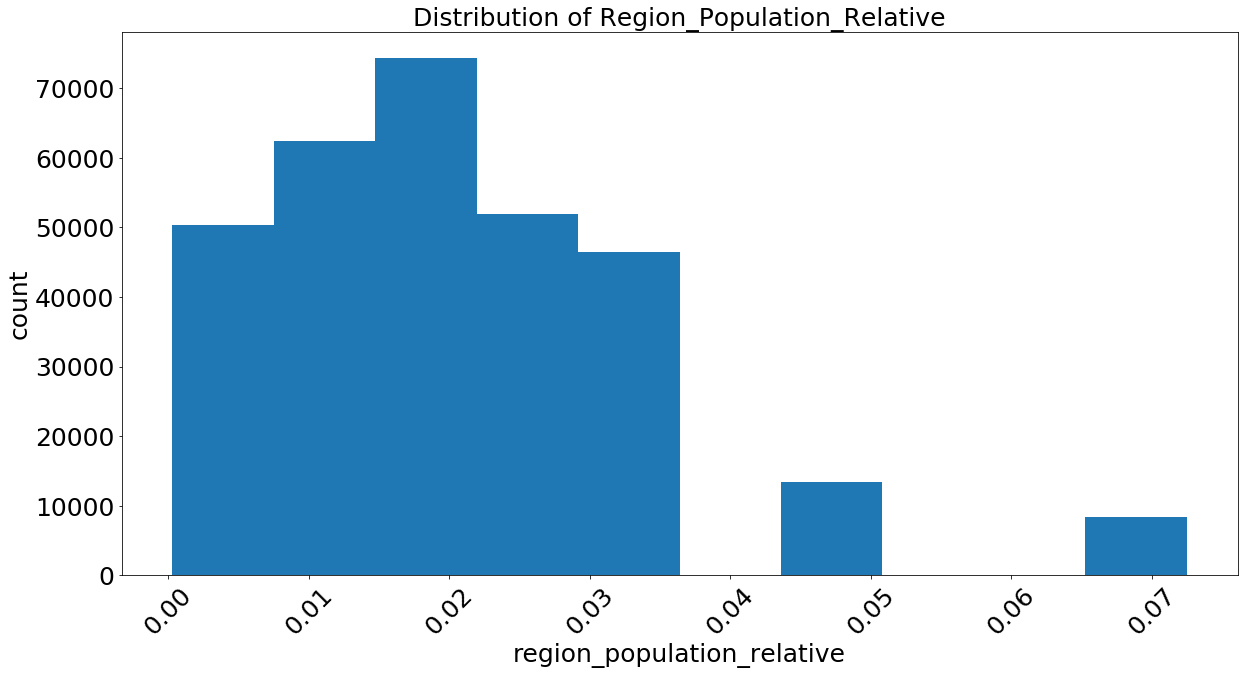

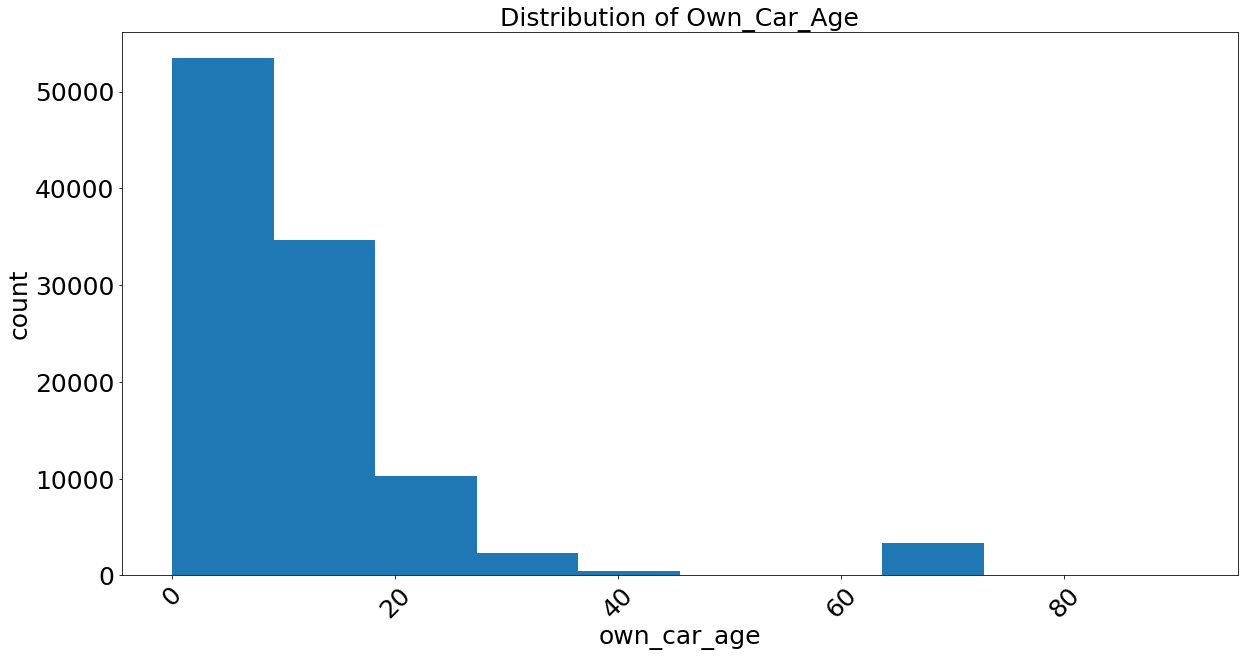

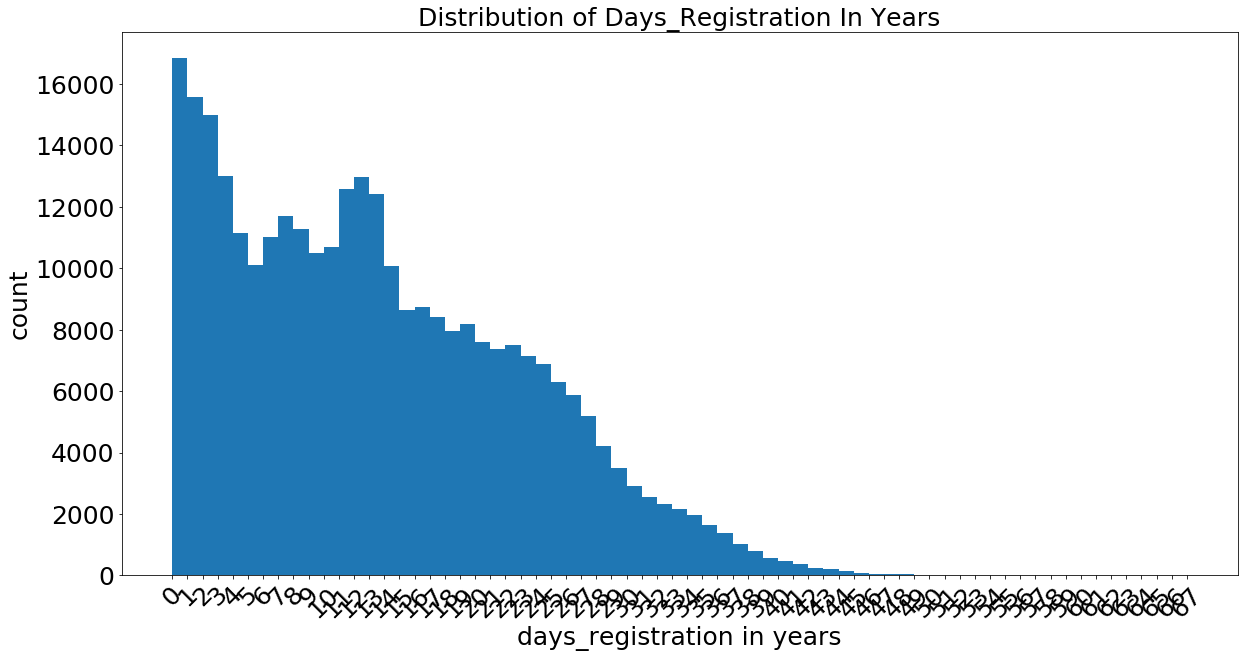

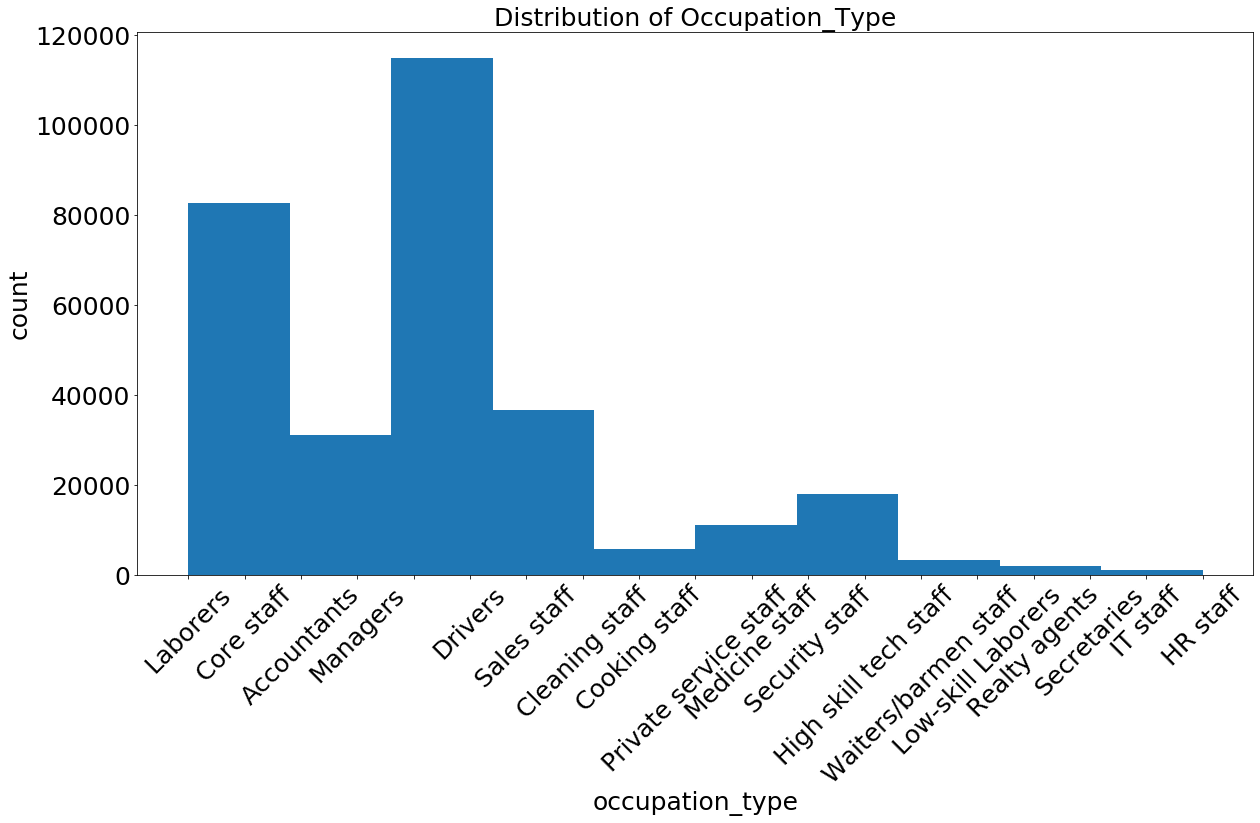

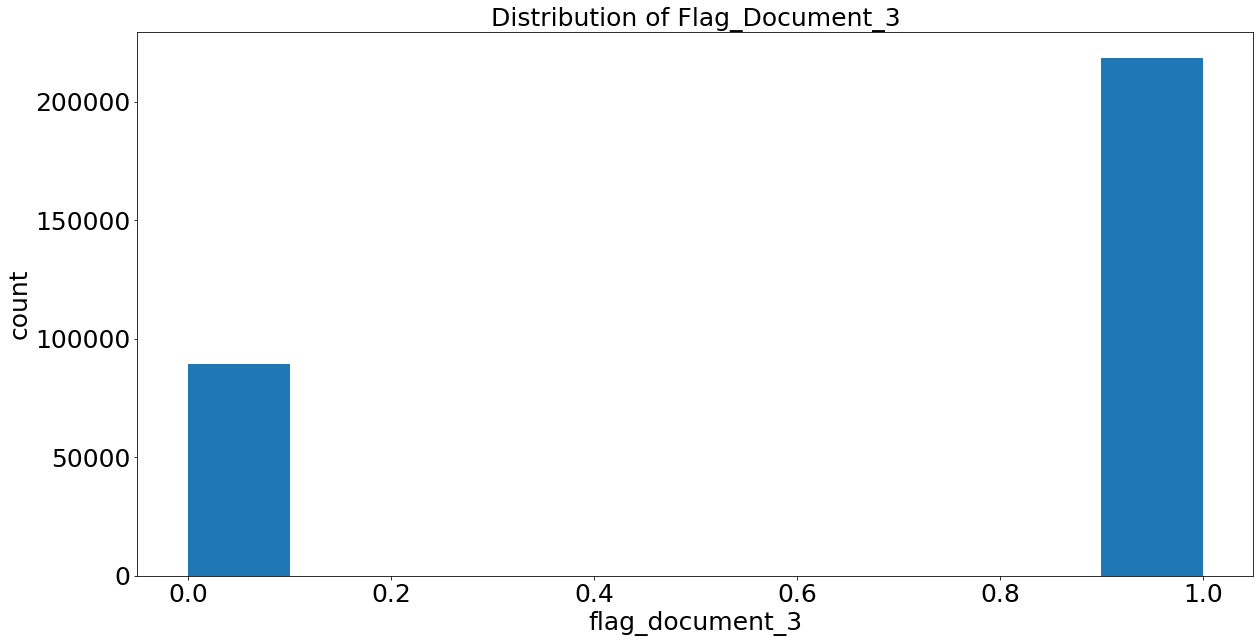

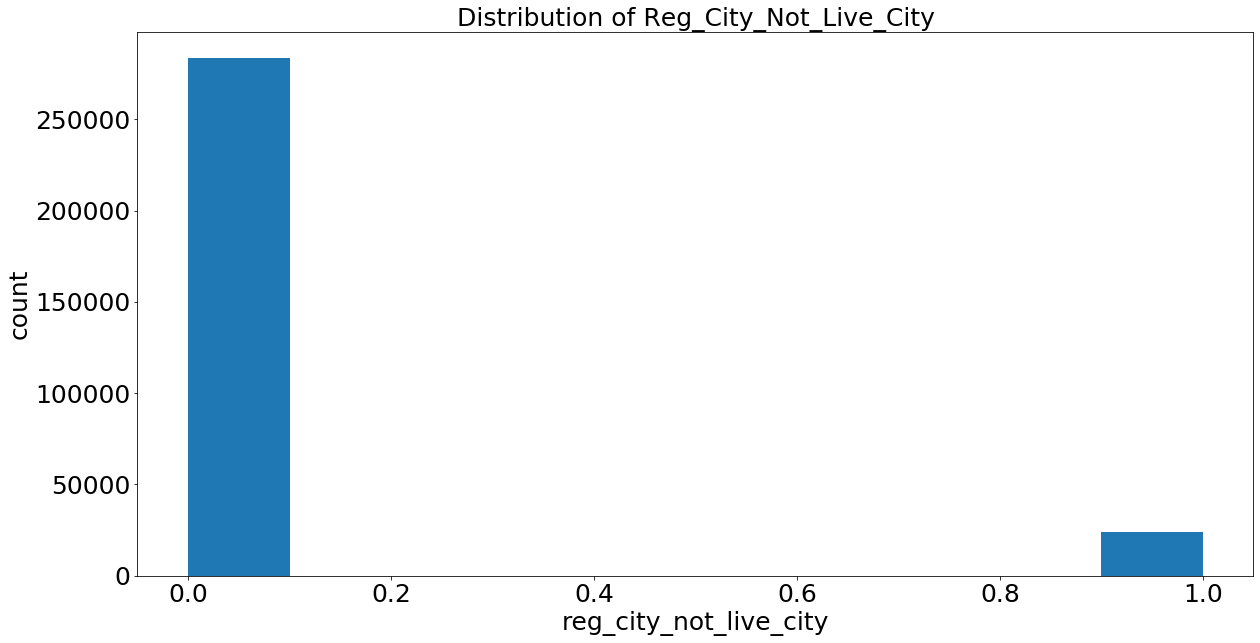

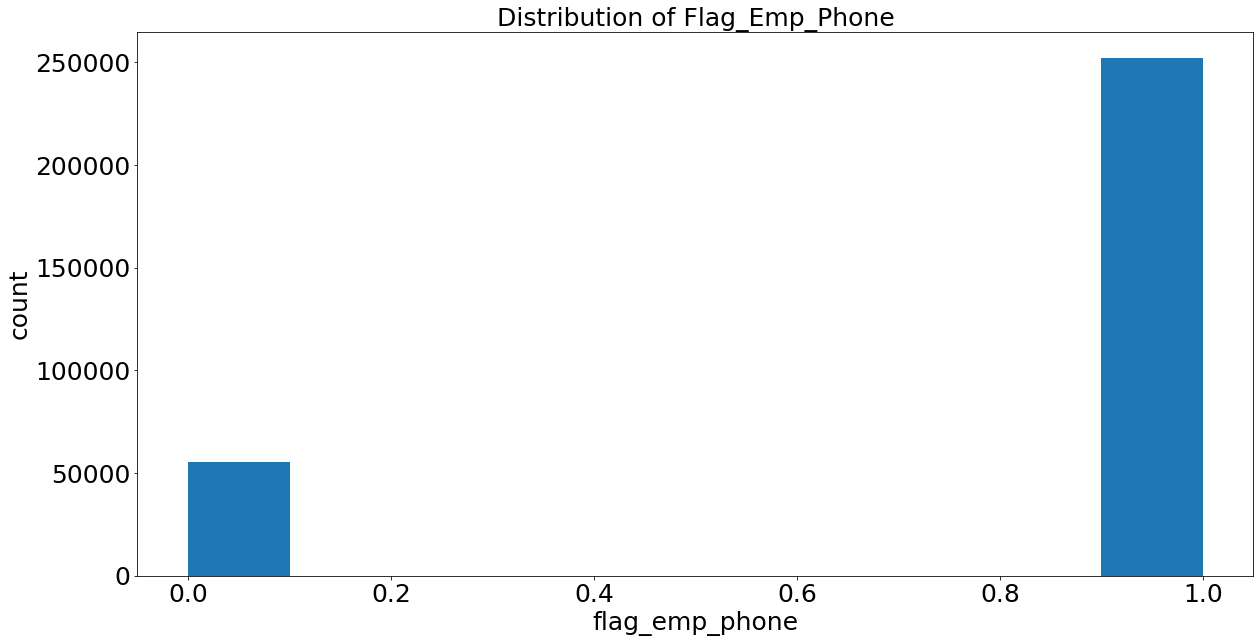

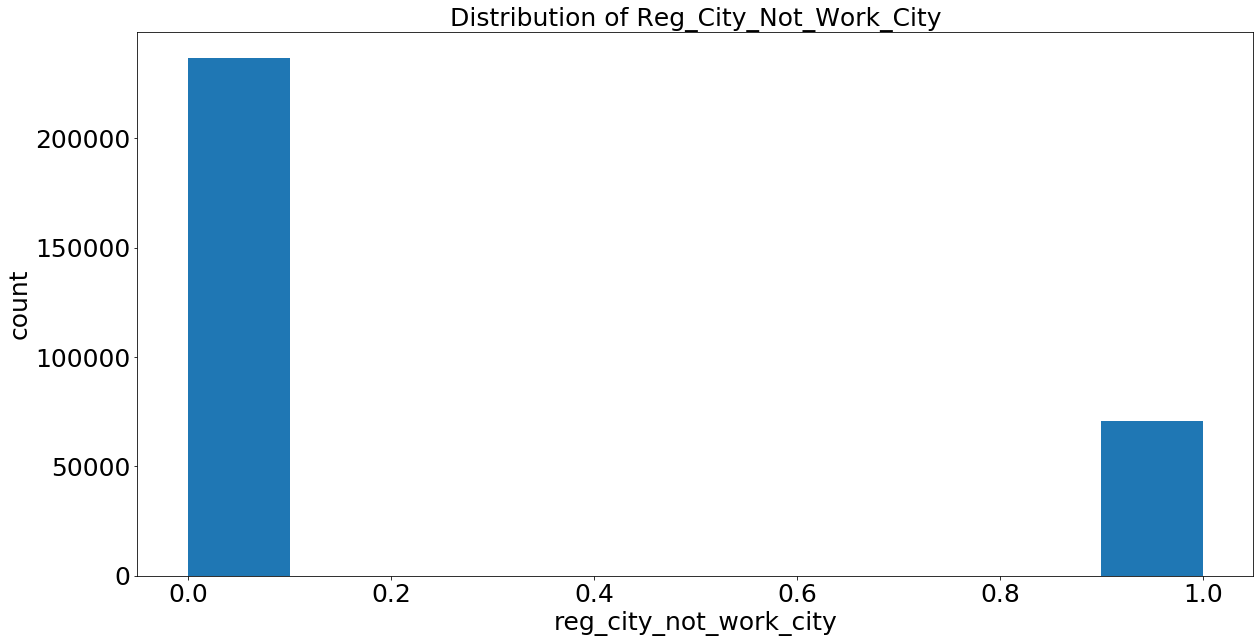

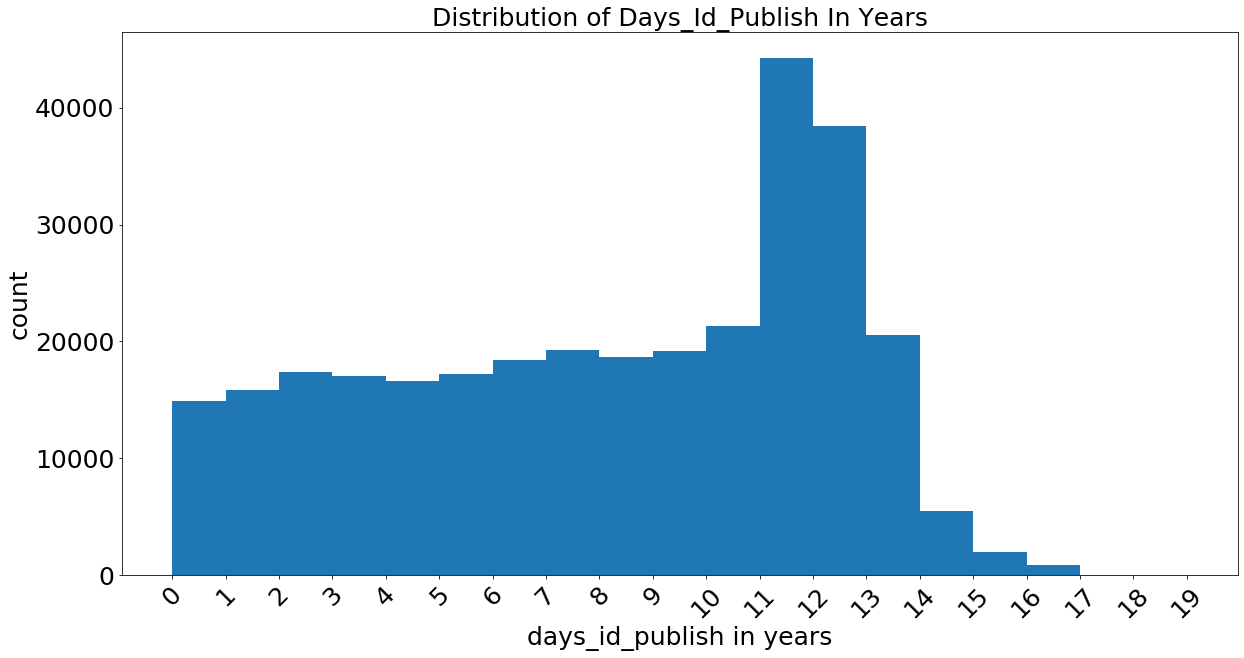

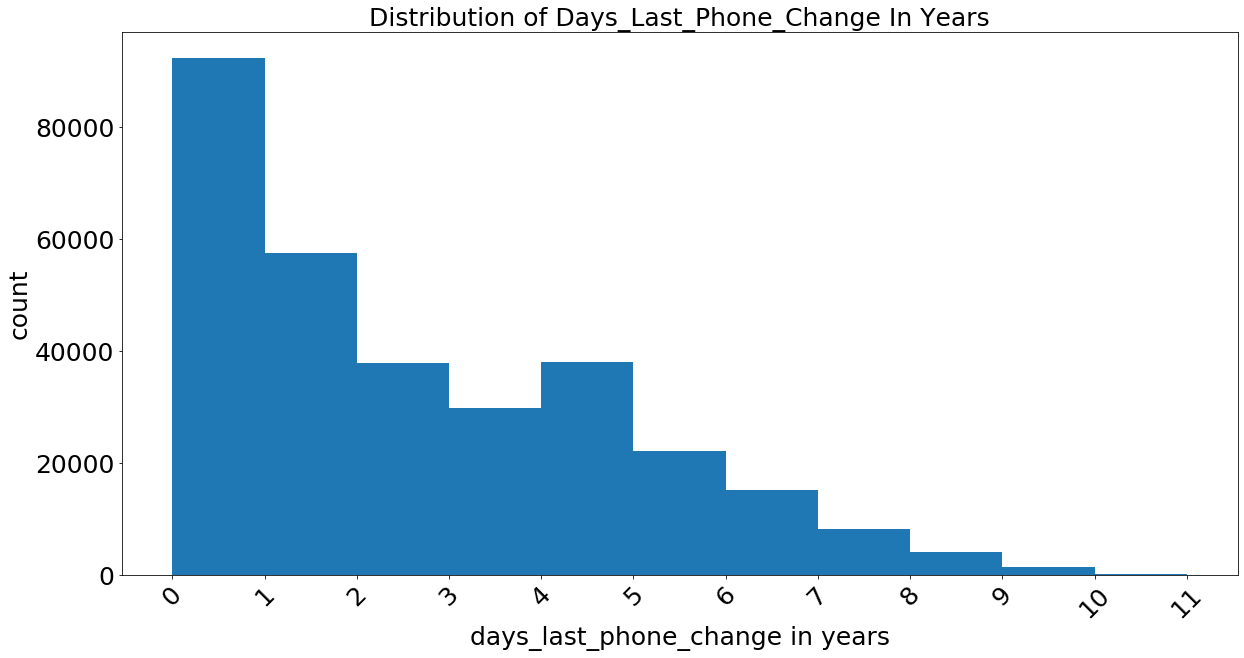

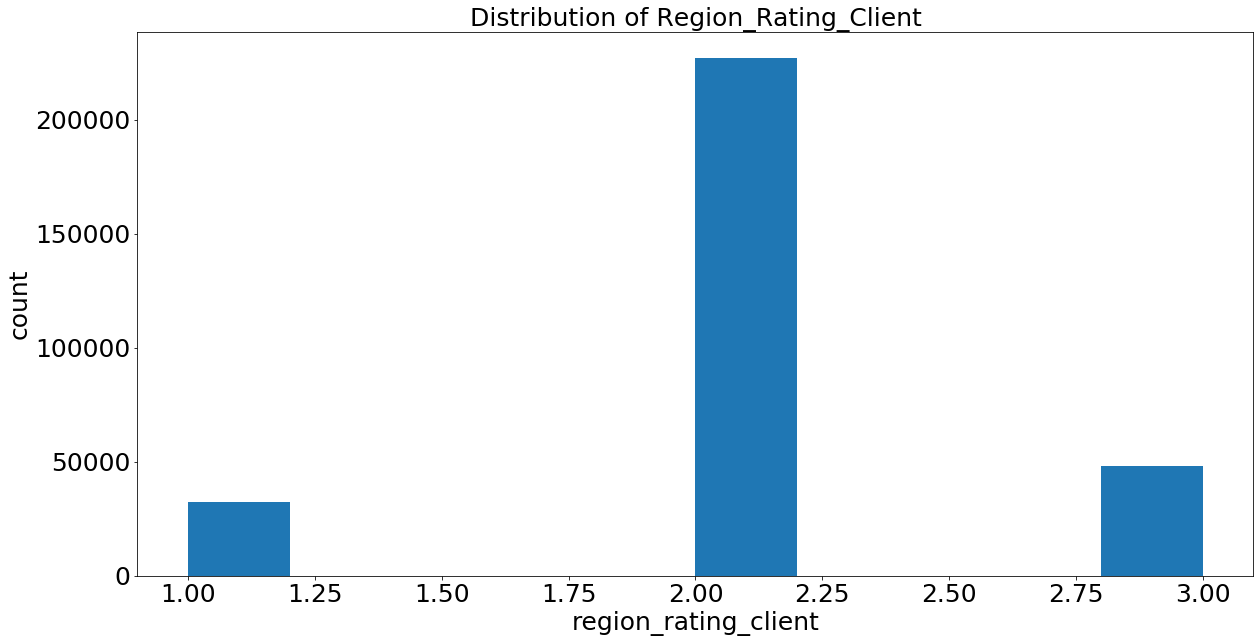

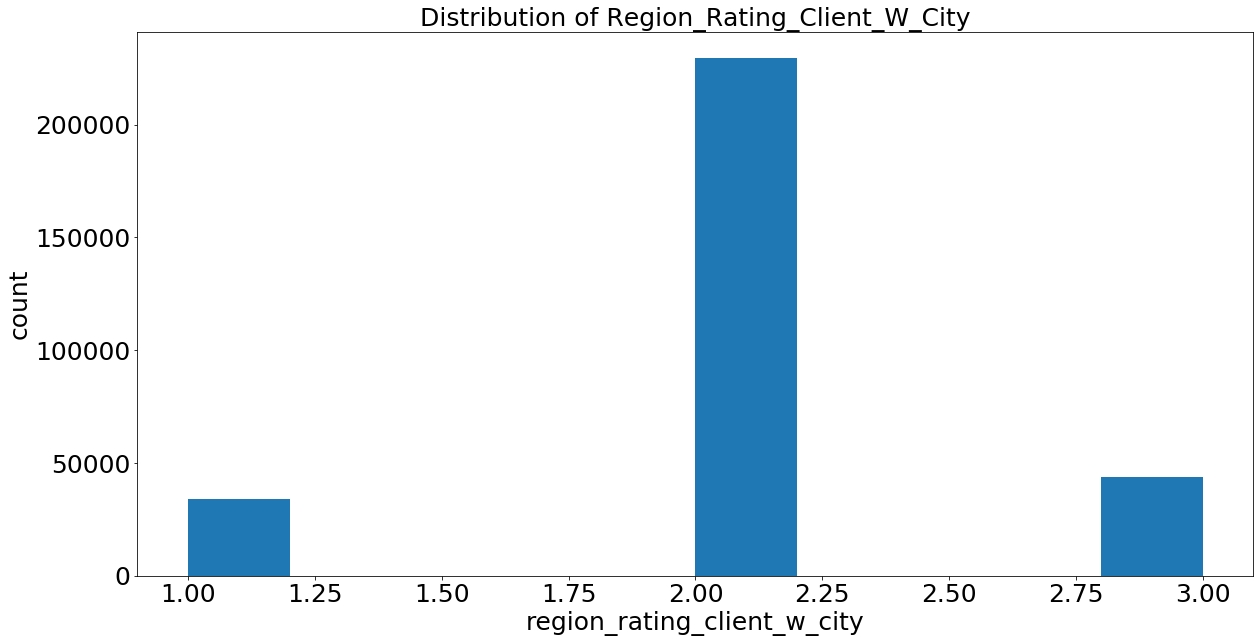

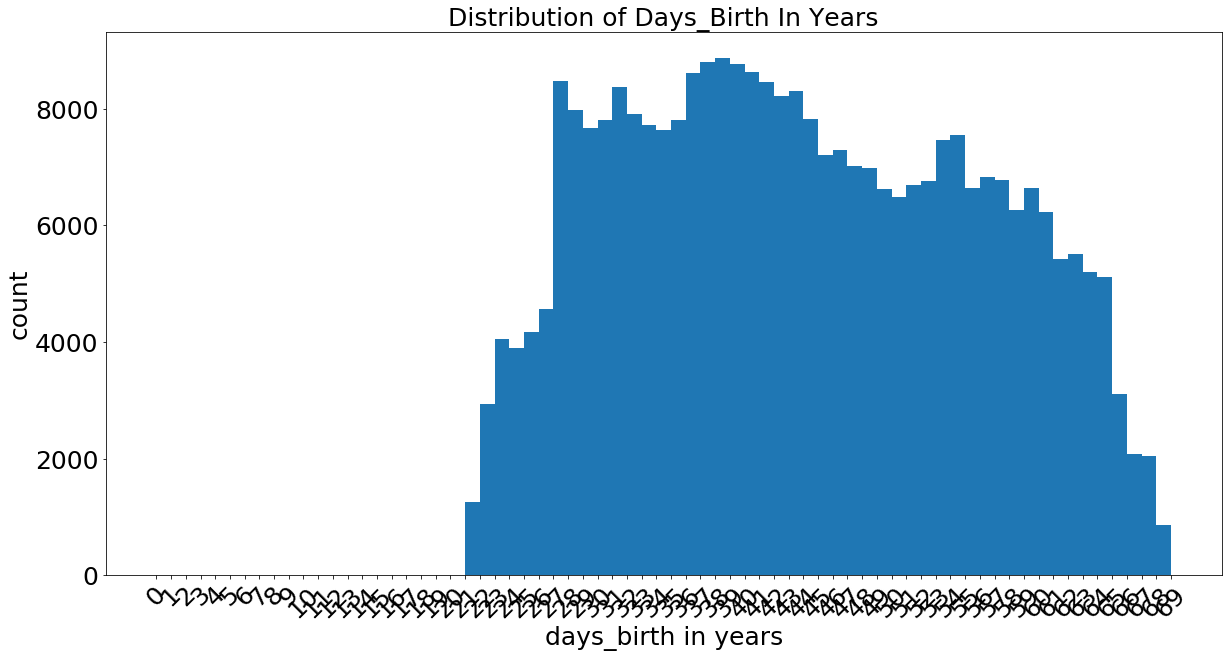

In [314]:
def plot_dist(df_in, col_list):
    
    df = df_in.copy()
    df = df[col_list]
    
    for col in df:
        plt.figure(figsize=(20,10))
        if 'days' in col:
            df[col] = df[col] / -365
            bins = np.arange(0, df[col].max(), 1)
            plt.hist(df[col], bins=bins)
            plt.xticks(bins, fontsize=25)
            plt.yticks(fontsize=25)
            title = col.title() + ' In Years'
        else:
            plt.hist(df[col])
            title = col.title()
            plt.xticks(fontsize=25)
            plt.yticks(fontsize=25)
        plt.title('Distribution of {}'.format(title), fontsize=25)
        plt.xlabel(title.lower(), fontsize=25)
        plt.ylabel('count', fontsize=25)
        if len(df[col].unique()) > 4:
            plt.xticks(rotation=45)
        plt.savefig('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}_hist.png'.format(col))
        plt.show()
        
        
plot_dist(train, ads_used_lower)

In [52]:
temp = train.copy()
    
cat_vars = list(metrics[(metrics['dtype'] == 'object') & ((metrics['unique_vals'] > 3) | ((metrics['unique_vals'] == 3) & (metrics['missing_perc'] == 0)))]['column'])

for col in temp.columns:
    if col in list(metrics[(metrics['dtype'] == 'object')]['column']) and col not in cat_vars:
        unique_vals = list(temp[col].unique())
        print('{} with {} coded as 0'.format(col, unique_vals[0]))
        temp[col] = np.where((temp[col] == unique_vals[0]), 0, 1)
        
seen = []
corrs = pd.DataFrame()
for col1 in temp.columns:
    if col1 == 'target' or col1[-4:] == 'mode' or col1[-4:] == 'medi' or col1[-4:] == '_avg' or 'flag_document' in col1 or col1 in cat_vars:
        continue
    for col2 in temp.columns:
        if col1 == col2 or col2 + ', ' + col1 in seen or col2 in cat_vars or col2 == 'target':
            continue
        temp1 = temp.copy()
        temp1 = temp1[(temp1[col1].isnull() == False) & (temp1[col1] != '') & (temp1[col2].isnull() == False) & (temp1[col2] != '')]
        corr = np.corrcoef(temp1[col1], temp1[col2])[0,1]
        seen.append(col1 + ', ' + col2)
        corrs = corrs.append({'col1': col1, 'col2': col2, 'corr': corr}, ignore_index=True)

corrs_target = pd.DataFrame()
for col in temp.columns:
    if col not in cat_vars and col != 'target':
        temp1 = temp.copy()
        temp1 = temp1[(temp1[col].isnull() == False) & (temp1[col] != '')]
        corr = np.corrcoef(temp1['target'], temp1[col])[0,1]
        corrs_target = corrs_target.append({'col': col, 'corr': corr}, ignore_index=True)

name_contract_type with Cash loans coded as 0
code_gender with M coded as 0
flag_own_car with N coded as 0
flag_own_realty with Y coded as 0
emergencystate_mode with N coded as 0


In [53]:
corrs['abs_corr'] = abs(corrs['corr'])
corrs_target['abs_corr'] = abs(corrs_target['corr'])
dfi.export(corrs[abs(corrs['corr']) > 0.70].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/func_dependencies.png', max_rows=150)
dfi.export(corrs.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_nontarget.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[0:20].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget_1.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[21:40].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget_2.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[41:60].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget_3.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[61:80].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget_4.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[81:100].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget_5.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[101:].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget_6.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[0:20].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target_1.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[21:40].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target_2.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[41:60].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target_3.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[61:80].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target_4.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[81:100].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target_5.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).reset_index(drop=True).loc[101:].style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target_6.png', max_rows=150)
dfi.export(corrs_target[(abs(corrs_target['corr']) >= 0.03)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_large_target.png', max_rows=150)
display(corrs[abs(corrs['corr']) > 0.70])
display(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1))
display(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'],axis=1))
correlations = train.corr()['target'].sort_values()
correlations

,col1,col2,corr,abs_corr
551,cnt_children,cnt_fam_members,0.879161,0.879161
742,amt_credit,amt_annuity,0.770138,0.770138
743,amt_credit,amt_goods_price,0.986968,0.986968
844,amt_annuity,amt_goods_price,0.775109,0.775109
2254,region_rating_client,region_rating_client_w_city,0.950842,0.950842
2592,reg_region_not_work_region,live_region_not_work_region,0.860627,0.860627
2835,reg_city_not_work_city,live_city_not_work_city,0.825575,0.825575
3265,obs_30_cnt_social_circle,obs_60_cnt_social_circle,0.998490,0.998490
3339,def_30_cnt_social_circle,def_60_cnt_social_circle,0.860517,0.860517


,col1,col2,corr
1149,days_birth,flag_emp_phone,0.619888
1164,days_birth,ext_source_1,-0.600610
1787,flag_emp_phone,flag_document_6,-0.597732
1057,region_population_relative,region_rating_client,-0.532877
1058,region_population_relative,region_rating_client_w_city,-0.531535
192,name_contract_type,flag_document_3,-0.479724
2509,reg_region_not_live_region,reg_region_not_work_region,0.450804
2755,reg_city_not_live_city,reg_city_not_work_city,0.440409
1220,days_birth,flag_document_6,-0.407160
1144,days_birth,days_employed,0.352321


,col,corr
34,ext_source_3,-0.178919
33,ext_source_2,-0.160472
32,ext_source_1,-0.155317
11,days_birth,0.078239
12,days_employed,0.074958
24,region_rating_client_w_city,0.060893
23,region_rating_client,0.058899
83,days_last_phone_change,0.055218
2,code_gender,-0.054713
14,days_id_publish,0.051457


ext_source_3                   -0.178919
ext_source_2                   -0.160472
ext_source_1                   -0.155317
floorsmax_avg                  -0.044003
floorsmax_medi                 -0.043768
floorsmax_mode                 -0.043226
amt_goods_price                -0.039645
region_population_relative     -0.037227
elevators_avg                  -0.034199
elevators_medi                 -0.033863
floorsmin_avg                  -0.033614
floorsmin_medi                 -0.033394
livingarea_avg                 -0.032997
livingarea_medi                -0.032739
floorsmin_mode                 -0.032698
totalarea_mode                 -0.032596
elevators_mode                 -0.032131
livingarea_mode                -0.030685
amt_credit                     -0.030369
apartments_avg                 -0.029498
apartments_medi                -0.029184
flag_document_6                -0.028602
apartments_mode                -0.027284
livingapartments_avg           -0.025031
livingapartments

In [211]:
train['age_years'] = np.ceil((train['days_birth'] * -1) / 365)
train['employed_years'] = np.ceil((train['days_employed'] * -1) / 365)
for col in ['code_gender', 'name_education_type', 'name_family_status', 'name_housing_type', 'age_years', 'employed_years']:
    print(train['amt_income_total'].median())
    display(train.groupby(col)['amt_income_total'].median())

147150.0


code_gender
     182250.0
F    135000.0
M    180000.0
Name: amt_income_total, dtype: float64

147150.0


name_education_type
Academic degree                  211500.0
Higher education                 180000.0
Incomplete higher                157500.0
Lower secondary                  112500.0
Secondary / secondary special    135000.0
Name: amt_income_total, dtype: float64

147150.0


name_family_status
Civil marriage          153000.0
Married                 157500.0
Separated               157500.0
Single / not married    144000.0
Unknown                 326250.0
Widow                   130500.0
Name: amt_income_total, dtype: float64

147150.0


name_housing_type
Co-op apartment        148500.0
House / apartment      148500.0
Municipal apartment    153000.0
Office apartment       157500.0
Rented apartment       148500.0
With parents           135000.0
Name: amt_income_total, dtype: float64

147150.0


age_years
21.0    112500.0
22.0    112500.0
23.0    135000.0
24.0    135000.0
25.0    135000.0
26.0    135000.0
27.0    137250.0
28.0    143451.0
29.0    148500.0
30.0    157500.0
31.0    157500.0
32.0    157500.0
33.0    157500.0
34.0    157500.0
35.0    157500.0
36.0    157500.0
37.0    157500.0
38.0    157500.0
39.0    157500.0
40.0    157500.0
41.0    157500.0
42.0    157500.0
43.0    157500.0
44.0    157500.0
45.0    157500.0
46.0    157500.0
47.0    157500.0
48.0    157500.0
49.0    157500.0
50.0    157500.0
51.0    157500.0
52.0    157500.0
53.0    157500.0
54.0    144000.0
55.0    135000.0
56.0    137700.0
57.0    135000.0
58.0    135000.0
59.0    135000.0
60.0    135000.0
61.0    135000.0
62.0    135000.0
63.0    126000.0
64.0    135000.0
65.0    121500.0
66.0    112500.0
67.0    110250.0
68.0    112500.0
69.0    112500.0
70.0    121500.0
Name: amt_income_total, dtype: float64

147150.0


employed_years
-0.0     150750.00
 1.0     135000.00
 2.0     153000.00
 3.0     157500.00
 4.0     157500.00
 5.0     157500.00
 6.0     157500.00
 7.0     157500.00
 8.0     157500.00
 9.0     157500.00
 10.0    157500.00
 11.0    157500.00
 12.0    157500.00
 13.0    157500.00
 14.0    157500.00
 15.0    157500.00
 16.0    157500.00
 17.0    157500.00
 18.0    157500.00
 19.0    157500.00
 20.0    157500.00
 21.0    157500.00
 22.0    153000.00
 23.0    157500.00
 24.0    157500.00
 25.0    148500.00
 26.0    135000.00
 27.0    135000.00
 28.0    157500.00
 29.0    157500.00
 30.0    145329.75
 31.0    157500.00
 32.0    157500.00
 33.0    157500.00
 34.0    148500.00
 35.0    157500.00
 36.0    157500.00
 37.0    157500.00
 38.0    168750.00
 39.0    157500.00
 40.0    162000.00
 41.0    180000.00
 42.0    157500.00
 43.0    159750.00
 44.0    175500.00
 45.0    177750.00
 46.0    164250.00
 47.0    155250.00
 48.0    135000.00
 49.0    153000.00
 50.0    180000.00
Name: amt_income

In [87]:
# From this point on, we will implement Hanane's final model and examine the outcomes

df = train_in.copy()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()

label_encode = LabelEncoder()

for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            label_encode.fit(df[col])
            df[col] = label_encode.transform(df[col])
            

df = pd.get_dummies(df)
display(df.head(1))

ft_list = ['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_XNA',
 'DAYS_EMPLOYED',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'EMERGENCYSTATE_MODE_NO',
 'HOUSETYPE_MODE_block of flats',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE',
 'DAYS_REGISTRATION',
 'OCCUPATION_TYPE_Laborers',
 'FLAG_DOCUMENT_3',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_EMP_PHONE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_ID_PUBLISH',
 'CODE_GENDER_M',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_INCOME_TYPE_Working',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_BIRTH',
 'TARGET']

ft_list = [x.lower() for x in ft_list]
df = df[ft_list]

# create X_train, y_train
X_train = df.drop('target', axis = 1)
y_train = df['target']
target = y_train
features = X_train
# Feature names
features_list = list(X_train.columns)

#Impute missing values using median strategy
imputer = SimpleImputer(strategy = 'median')

#Scale all values in 0-1 range
scaler = MinMaxScaler(feature_range = (0, 1))

#fit the imputer on training set
imputer.fit(X_train)

#transform both training and testing data
X_train = imputer.transform(X_train)

#fit scaler and transform
scaler.fit(X_train)
train_scaled = scaler.transform(X_train)


,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,code_gender_f,code_gender_m,code_gender_xna,name_type_suite_children,name_type_suite_family,name_type_suite_group of people,name_type_suite_other_a,name_type_suite_other_b,"name_type_suite_spouse, partner",name_type_suite_unaccompanied,name_income_type_businessman,name_income_type_commercial associate,name_income_type_maternity leave,name_income_type_pensioner,name_income_type_state servant,name_income_type_student,name_income_type_unemployed,name_income_type_working,name_education_type_academic degree,name_education_type_higher education,name_education_type_incomplete higher,name_education_type_lower secondary,name_education_type_secondary / secondary special,name_family_status_civil marriage,name_family_status_married,name_family_status_separated,name_family_status_single / not married,name_family_status_unknown,name_family_status_widow,name_housing_type_co-op apartment,name_housing_type_house / apartment,name_housing_type_municipal apartment,name_housing_type_office apartment,name_housing_type_rented apartment,name_housing_type_with parents,occupation_type_accountants,occupation_type_cleaning staff,occupation_type_cooking staff,occupation_type_core staff,occupation_type_drivers,occupation_type_high skill tech staff,occupation_type_hr staff,occupation_type_it staff,occupation_type_laborers,occupation_type_low-skill laborers,occupation_type_managers,occupation_type_medicine staff,occupation_type_private service staff,occupation_type_realty agents,occupation_type_sales staff,occupation_type_secretaries,occupation_type_security staff,occupation_type_waiters/barmen staff,weekday_appr_process_start_friday,weekday_appr_process_start_monday,weekday_appr_process_start_saturday,weekday_appr_process_start_sunday,weekday_appr_process_start_thursday,weekday_appr_process_start_tuesday,weekday_appr_process_start_wednesday,organization_type_advertising,organization_type_agriculture,organization_type_bank,organization_type_business entity type 1,organization_type_business entity type 2,organization_type_business 

In [244]:
tuned_lgbm_model = lgbm.LGBMClassifier(n_estimators= 500, learning_rate = 0.09913706634323802, 
                                       num_leaves = 900, max_depth = 8, min_data_in_leaf = 600)

In [245]:
train_features, test_features, train_labels, test_labels = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
tuned_lgbm_model.fit(train_features, train_labels)

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600


LGBMClassifier(learning_rate=0.09913706634323802, max_depth=8,
               min_data_in_leaf=600, n_estimators=500, num_leaves=900)

In [246]:
tuned_lgbm_predictions = tuned_lgbm_model.predict(test_features)

In [92]:
def get_scores (preds): 
    print('Accuracy: %.3f' % accuracy_score(test_labels.values, preds))
    print('Precision: %.3f' % precision_score(test_labels.values, preds))
    print('Recall: %.3f' % recall_score(test_labels.values, preds))
    print('F1: %.3f' % f1_score(test_labels.values, preds))

print('Tuned LGBM scores: ')
get_scores(tuned_lgbm_predictions)

Tuned LGBM scores: 
Accuracy: 0.919
Precision: 0.471
Recall: 0.026
F1: 0.050


In [98]:
print(len(tuned_lgbm_predictions))
print(np.sum(tuned_lgbm_predictions))
print(np.sum(test_labels))

61503
278
4949


In [298]:
df_test = pd.DataFrame(test_features, columns=[x for x in df.columns if x != 'target'])
df_test['true'] = list(test_labels)
df_test['pred'] = tuned_lgbm_predictions

df_test['age_years'] = np.ceil((df_test['days_birth'] * -1) / 365)
df_test['emp_years'] = np.ceil((df_test['days_employed'] * -1) / 365)

df_test['age_group'] = ''
df_test['age_group'] = np.where((df_test['age_years'] < 30), '<30', df_test['age_group'])
df_test['age_group'] = np.where((df_test['age_years'] >= 30) & (df_test['age_years'] < 40), '30-39', df_test['age_group'])
df_test['age_group'] = np.where((df_test['age_years'] >= 40) & (df_test['age_years'] < 50), '40-49', df_test['age_group'])
df_test['age_group'] = np.where((df_test['age_years'] >= 50) & (df_test['age_years'] < 60), '50-59', df_test['age_group'])
df_test['age_group'] = np.where((df_test['age_years'] >= 60), '60+', df_test['age_group'])

df_test['emp_group'] = ''
df_test['emp_group'] = np.where((df_test['emp_years'] >= 0) & (df_test['emp_years'] < 5), '0-4', df_test['emp_group'])
df_test['emp_group'] = np.where((df_test['emp_years'] >= 5) & (df_test['emp_years'] < 10), '5-9', df_test['emp_group'])
df_test['emp_group'] = np.where((df_test['emp_years'] >= 10) & (df_test['emp_years'] < 20), '10-19', df_test['emp_group'])
df_test['emp_group'] = np.where((df_test['emp_years'] >= 20), '20+', df_test['emp_group'])

In [328]:
def compute_metrics(df, var):
    
    fp = 0
    tp = 0
    fn = 0
    tn = 0

    table = pd.DataFrame()
    if var == 'all':
        for index, row in df.iterrows():
            if row['pred'] == 1 and row['true'] == 0:
                fp += 1
            elif row['pred'] == 0 and row['true'] == 1:
                fn += 1
            elif row['pred'] == 1 and row['true'] == 1:
                tp += 1
            elif row['pred'] == 0 and row['true'] == 0:
                tn += 1

        accuracy = (tp + tn) / len(df)
        fp_rate = fp / (fp + tn)
        fn_rate = 1 - (fn / (tp + fn))

        print("Accuracy for {}: {:.1%}".format(var, accuracy))
        print("FP Rate for {}: {:.1%}".format(var, fp_rate))
        print("FN Rate for {}: {:.1%}".format(var, fn_rate))
        print("\n")
            
    else:
        for sub_pop in df[var].unique():

            df_filt = df.copy()
            df_filt = df_filt[df_filt[var] == sub_pop]

            for index, row in df_filt.iterrows():
                if row['pred'] == 1 and row['true'] == 0:
                    fp += 1
                elif row['pred'] == 0 and row['true'] == 1:
                    fn += 1
                elif row['pred'] == 1 and row['true'] == 1:
                    tp += 1
                elif row['pred'] == 0 and row['true'] == 0:
                    tn += 1

            accuracy = (tp + tn) / len(df_filt)
            fp_rate = fp / (fp + tn)
            fn_rate = 1 - (fn / (tp + fn))

            table = table.append({'group': var + ' ' + str(sub_pop), 'acc': accuracy, 'fp': fp_rate, 'fn': fn_rate}, ignore_index=True)

    display(table)


In [329]:
compute_metrics(df_test, 'all')
compute_metrics(df_test, 'code_gender_f')
compute_metrics(df_test, 'age_group')
compute_metrics(df_test, 'emp_group')

Accuracy for all: 91.9%
FP Rate for all: 0.3%
FN Rate for all: 2.6%




""


,group,acc,fp,fn
0,code_gender_f 0.0,0.897944,0.004894,0.033602
1,code_gender_f 1.0,1.392802,0.002599,0.026470


,group,acc,fp,fn
0,age_group 30-39,0.899096,0.003355,0.035173
1,age_group 40-49,1.853031,0.003121,0.032862
2,age_group 50-59,3.106340,0.002611,0.027725
3,age_group 60+,5.837158,0.002246,0.025353
4,age_group <30,7.506373,0.002599,0.026470


,group,acc,fp,fn
0,emp_group 0-4,0.890836,0.005602,0.039968
1,emp_group 20+,8.010399,0.004930,0.038625
2,emp_group,3.038190,0.003543,0.032441
3,emp_group 5-9,3.071268,0.002983,0.028675
4,emp_group 10-19,6.187808,0.002599,0.026470


In [206]:
temp = train.copy()
temp = temp[(temp['floorsmax_avg'].isnull() == False) & (temp['floorsmax_avg'] != '') & (temp['floorsmax_medi'].isnull() == False) & (temp['floorsmax_medi'] != '')]
corr = np.corrcoef(temp['floorsmax_avg'], temp['floorsmax_medi'])[0,1]
print(corr)

0.997034142034968


In [253]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

In [293]:
# convert this dataframe into an aif360 dataset
df_nonull = df.copy()
for col in df_nonull.columns:
    df_nonull = df_nonull[(df_nonull[col].isnull() == False) & (df_nonull[col] != '')]
protected_attr = 'code_gender_f'
target = 'target'
dataset_orig = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df_nonull,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 0}] 
unprivileged_groups = [{protected_attr: 1}]

In [294]:
# Convert to dataframes
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed=10)
train_orig, val_orig = train_orig.split([0.875], shuffle=True, seed=5)

# Convert to dataframes
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (14681, 31)
Val set:  (2098, 31)
Test set:  (4195, 31)


In [295]:
lgbm_aif = lgbm.LGBMClassifier(n_estimators= 500, learning_rate = 0.09913706634323802, 
                                       num_leaves = 900, max_depth = 8, min_data_in_leaf = 600)

X_train_aif = train_orig_df.drop(['target'],axis=1).values
y_train_aif = train_orig_df[['target']].values
X_test_aif = test_orig_df.drop(['target'],axis=1).values
y_test_aif = test_orig_df[['target']].values

In [296]:
lgbm_aif.fit(X_train_aif, y_train_aif)
y_pred = lgbm_aif.predict(X_test_aif)

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600


In [297]:
def compute_acc(y_pred, y_test):

    correct = 0

    for pred, true in zip(y_pred, y_test):
        if pred == true:
            correct += 1

    return correct / len(y_pred)

def compute_acc_group(y_pred, y_test, test_orig_df):

    test_orig_df = test_orig_df.reset_index(drop=True)

    correct_priv = 0
    correct_unpriv = 0

    total_priv = len(test_orig_df[test_orig_df['code_gender_f'] == 0])
    total_unpriv = len(test_orig_df[test_orig_df['code_gender_f'] == 1])

    for index, row in test_orig_df.iterrows():
        if row['code_gender_f'] == 0 and y_pred[index] == y_test[index][0]:
            correct_priv += 1
        elif row['code_gender_f'] == 1 and y_pred[index] == y_test[index][0]:
            correct_unpriv += 1
    
    return correct_priv / total_priv, correct_unpriv / total_unpriv

def compute_fp(y_pred, y_test, test_orig_df):

    fp_priv = 0
    tn_priv = 0
    fp_unpriv = 0
    tn_unpriv = 0

    test_orig_df = test_orig_df.reset_index(drop=True)

    for index, row in test_orig_df.iterrows():
        if row['code_gender_f'] == 0 and y_pred[index] == 1 and y_test[index][0] == 0:
            fp_priv += 1
        elif row['code_gender_f'] == 0 and y_pred[index] == 0 and y_test[index][0] == 0:
            tn_priv += 1
        elif row['code_gender_f'] == 1 and y_pred[index] == 1 and y_test[index][0] == 0:
            fp_unpriv += 1
        elif row['code_gender_f'] == 1 and y_pred[index] == 0 and y_test[index][0] == 0:
            tn_unpriv += 1

    fp_rate_priv = fp_priv / (fp_priv + tn_priv)
    fp_rate_unpriv = fp_unpriv / (fp_unpriv + tn_unpriv)

    return fp_rate_priv, fp_rate_unpriv

def calc_disparate_impact(df, y_pred):

    df_pred = df.copy()
    df_pred['target'] = y_pred

    privileged_groups = [{'code_gender_f': 0}]
    unprivileged_groups = [{'code_gender_f': 1}]  

    aif360_test = StandardDataset(df_pred, label_name='target', protected_attribute_names=['code_gender_f'], 
                privileged_classes=[[1]], favorable_classes=[1])
  
    metric_preds = BinaryLabelDatasetMetric(
    aif360_test, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )

    disparate_impact = metric_preds.disparate_impact()

    return disparate_impact

def calc_fp_diff(df, y_pred):

    privileged_groups = [{'code_gender_f': 0}]
    unprivileged_groups = [{'code_gender_f': 1}]

    orig_aif360 = StandardDataset(df, label_name='target', protected_attribute_names=['code_gender_f'], 
                privileged_classes=[[1]], favorable_classes=[1])
    pred_test_df = df.copy()
    pred_test_df['target'] = y_pred
    preds_aif360 = StandardDataset(pred_test_df, label_name='target', protected_attribute_names=['code_gender_f'], 
                  privileged_classes=[[1]], favorable_classes=[1])

    orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

    fp_rate_priv = orig_vs_preds_metrics.false_positive_rate(privileged=True)
    fp_rate_unpriv = orig_vs_preds_metrics.false_positive_rate(privileged=False)

    fp_diff = fp_rate_unpriv - fp_rate_priv

    return fp_diff

accuracy = compute_acc(y_pred, y_test_aif)
accuracy_priv, accuracy_unpriv = compute_acc_group(y_pred, y_test_aif, test_orig_df)
disparate_impact = calc_disparate_impact(test_orig_df, y_pred)
fp_diff = calc_fp_diff(test_orig_df, y_pred)

print("Accuracy of the model: {:.3%}".format(accuracy))
print("Accuracy of the privelaged group: {:.3%}".format(accuracy_priv))
print("Accuracy of the unprivelaged group: {:.3%}".format(accuracy_unpriv))
print("Disparate Impact: {:.3}".format(disparate_impact))
print("False Positive Rate Difference: {:.3%}".format(fp_diff))

Accuracy of the model: 93.659%
Accuracy of the privelaged group: 91.849%
Accuracy of the unprivelaged group: 95.470%
Disparate Impact: 0.227
False Positive Rate Difference: -0.777%


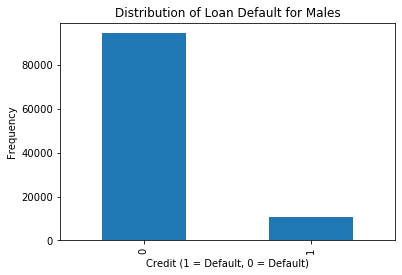

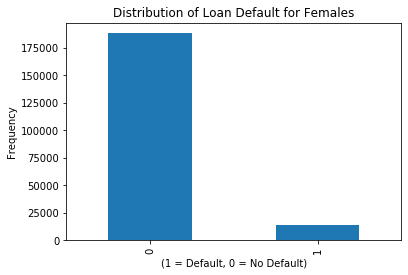

0.1014192025433328
0.06999328222555916
0.0
0.0


In [262]:
train[train['code_gender'] == 'M']['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Default for Males')
plt.xlabel("Credit (1 = Default, 0 = Default)")
plt.ylabel("Frequency")
plt.show()

train[train['code_gender'] == 'F']['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Default for Females')
plt.xlabel("(1 = Default, 0 = No Default)")
plt.ylabel("Frequency")
plt.show()

print(len(train[(train['code_gender'] == 'M') & (train['target'] == 1)]) / len(train[(train['code_gender'] == 'M')]))
print(len(train[(train['code_gender'] == 'F') & (train['target'] == 1)]) / len(train[(train['code_gender'] == 'F')]))

print(len(train[(train['code_gender'] == 'M') & (train['amt_income_total'].isnull() == True)]) / len(train[(train['code_gender'] == 'M')]))
print(len(train[(train['code_gender'] == 'F') & (train['amt_income_total'].isnull() == True)]) / len(train[(train['code_gender'] == 'F')]))

In [302]:
# convert this dataframe into an aif360 dataset
df_nonull = df.copy()
df_nonull['age_years'] = np.ceil((df_nonull['days_birth'] * -1) / 365)
df_nonull['age_group'] = np.where(df_nonull['age_years'] < 40, 1, 0)
for col in df_nonull.columns:
    df_nonull = df_nonull[(df_nonull[col].isnull() == False) & (df_nonull[col] != '')]
protected_attr = 'age_group'
target = 'target'
dataset_orig = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df_nonull,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 0}] 
unprivileged_groups = [{protected_attr: 1}]

In [303]:
# Convert to dataframes
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed=10)
train_orig, val_orig = train_orig.split([0.875], shuffle=True, seed=5)

# Convert to dataframes
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (14681, 33)
Val set:  (2098, 33)
Test set:  (4195, 33)


In [304]:
lgbm_aif = lgbm.LGBMClassifier(n_estimators= 500, learning_rate = 0.09913706634323802, 
                                       num_leaves = 900, max_depth = 8, min_data_in_leaf = 600)

X_train_aif = train_orig_df.drop(['target'],axis=1).values
y_train_aif = train_orig_df[['target']].values
X_test_aif = test_orig_df.drop(['target'],axis=1).values
y_test_aif = test_orig_df[['target']].values

In [305]:
lgbm_aif.fit(X_train_aif, y_train_aif)
y_pred = lgbm_aif.predict(X_test_aif)

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600


In [307]:
def compute_acc(y_pred, y_test):

    correct = 0

    for pred, true in zip(y_pred, y_test):
        if pred == true:
            correct += 1

    return correct / len(y_pred)

def compute_acc_group(y_pred, y_test, test_orig_df):

    test_orig_df = test_orig_df.reset_index(drop=True)

    correct_priv = 0
    correct_unpriv = 0

    total_priv = len(test_orig_df[test_orig_df['age_group'] == 0])
    total_unpriv = len(test_orig_df[test_orig_df['age_group'] == 1])

    for index, row in test_orig_df.iterrows():
        if row['age_group'] == 0 and y_pred[index] == y_test[index][0]:
            correct_priv += 1
        elif row['age_group'] == 1 and y_pred[index] == y_test[index][0]:
            correct_unpriv += 1
    
    return correct_priv / total_priv, correct_unpriv / total_unpriv

def compute_fp(y_pred, y_test, test_orig_df):

    fp_priv = 0
    tn_priv = 0
    fp_unpriv = 0
    tn_unpriv = 0

    test_orig_df = test_orig_df.reset_index(drop=True)

    for index, row in test_orig_df.iterrows():
        if row['age_group'] == 0 and y_pred[index] == 1 and y_test[index][0] == 0:
            fp_priv += 1
        elif row['age_group'] == 0 and y_pred[index] == 0 and y_test[index][0] == 0:
            tn_priv += 1
        elif row['age_group'] == 1 and y_pred[index] == 1 and y_test[index][0] == 0:
            fp_unpriv += 1
        elif row['age_group'] == 1 and y_pred[index] == 0 and y_test[index][0] == 0:
            tn_unpriv += 1

    fp_rate_priv = fp_priv / (fp_priv + tn_priv)
    fp_rate_unpriv = fp_unpriv / (fp_unpriv + tn_unpriv)

    return fp_rate_priv, fp_rate_unpriv

def calc_disparate_impact(df, y_pred):

    df_pred = df.copy()
    df_pred['target'] = y_pred

    privileged_groups = [{'age_group': 0}]
    unprivileged_groups = [{'age_group': 1}]  

    aif360_test = StandardDataset(df_pred, label_name='target', protected_attribute_names=['age_group'], 
                privileged_classes=[[1]], favorable_classes=[1])
  
    metric_preds = BinaryLabelDatasetMetric(
    aif360_test, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )

    disparate_impact = metric_preds.disparate_impact()

    return disparate_impact

def calc_fp_diff(df, y_pred):

    privileged_groups = [{'age_group': 0}]
    unprivileged_groups = [{'age_group': 1}]

    orig_aif360 = StandardDataset(df, label_name='target', protected_attribute_names=['age_group'], 
                privileged_classes=[[1]], favorable_classes=[1])
    pred_test_df = df.copy()
    pred_test_df['target'] = y_pred
    preds_aif360 = StandardDataset(pred_test_df, label_name='target', protected_attribute_names=['age_group'], 
                  privileged_classes=[[1]], favorable_classes=[1])

    orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

    fp_rate_priv = orig_vs_preds_metrics.false_positive_rate(privileged=True)
    fp_rate_unpriv = orig_vs_preds_metrics.false_positive_rate(privileged=False)

    fp_diff = fp_rate_unpriv - fp_rate_priv

    return fp_diff

accuracy = compute_acc(y_pred, y_test_aif)
accuracy_priv, accuracy_unpriv = compute_acc_group(y_pred, y_test_aif, test_orig_df)
disparate_impact = calc_disparate_impact(test_orig_df, y_pred)
fp_diff = calc_fp_diff(test_orig_df, y_pred)

print("Accuracy of the model: {:.3%}".format(accuracy))
print("Accuracy of the privelaged group: {:.3%}".format(accuracy_priv))
print("Accuracy of the unprivelaged group: {:.3%}".format(accuracy_unpriv))
print("Disparate Impact: {:.3}".format(disparate_impact))
print("False Positive Rate Difference: {:.3%}".format(fp_diff))

Accuracy of the model: 93.588%
Accuracy of the privelaged group: 94.364%
Accuracy of the unprivelaged group: 92.923%
Disparate Impact: 3.42
False Positive Rate Difference: 0.532%


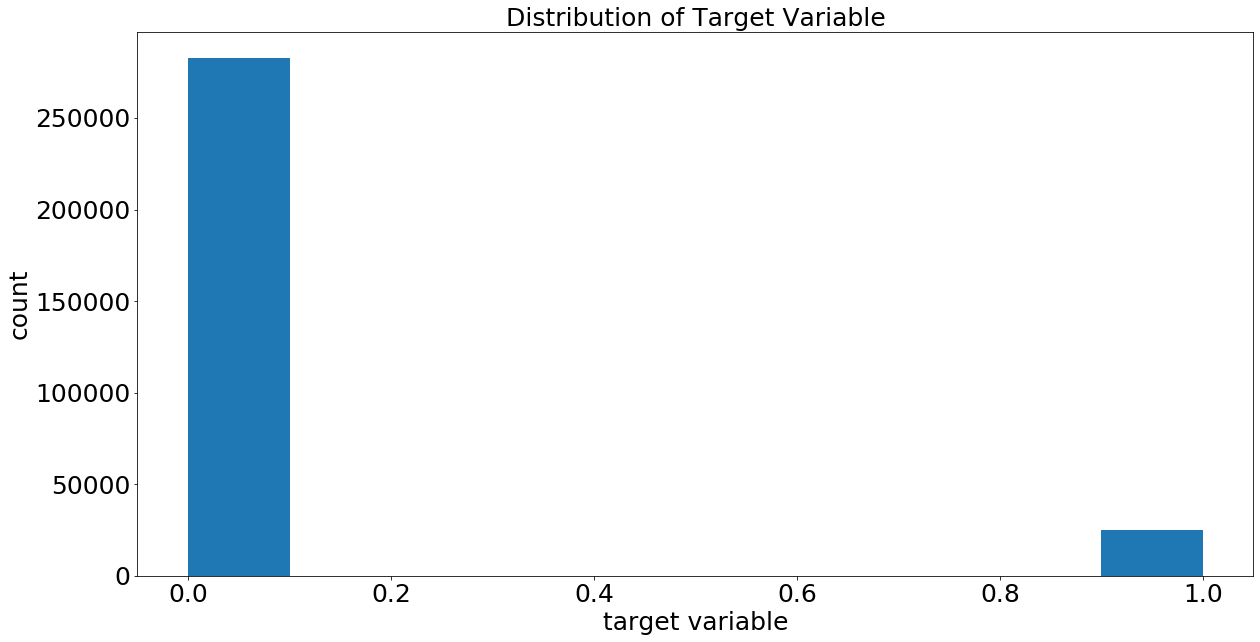

In [317]:
plt.figure(figsize=(20,10))

plt.hist(train_in['target'])
title = 'target variable'
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Distribution of {}'.format('Target Variable'), fontsize=25)
plt.xlabel(title.lower(), fontsize=25)
plt.ylabel('count', fontsize=25)
if len(df['target'].unique()) > 4:
    plt.xticks(rotation=45)
plt.savefig('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}_hist.png'.format('target_var'))
plt.show()
        


In [334]:
#!pip install lime
#!pip install future

In [337]:
import lime
import lime.lime_tabular
from lime import submodular_pick
import sklearn.ensemble
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#from _future_ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [338]:
# Get a list of feature names
# train_in.head()
feature_names = df.columns[:-1]

In [339]:
# Mark labels and encode them using sklearn
labels = df.iloc[:,-1]
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = df.iloc[:,:-1]
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)

Class names:  [0 1]
Label mapping:  {0: 0, 1: 1}


In [340]:
# Check if there are categorical varibles that we need to make dummies for
print(data.dtypes)
categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
print("Indices of categorical features: ", categorical_features)

ext_source_3                                         float64
ext_source_2                                         float64
ext_source_1                                         float64
name_education_type_higher education                   uint8
code_gender_f                                          uint8
name_income_type_pensioner                             uint8
organization_type_xna                                  uint8
days_employed                                          int64
floorsmax_avg                                        float64
floorsmax_medi                                       float64
floorsmax_mode                                       float64
emergencystate_mode_no                                 uint8
housetype_mode_block of flats                          uint8
amt_goods_price                                      float64
region_population_relative                           float64
own_car_age                                          float64
days_registration       

In [341]:
categorical_names = {}
for feature in categorical_features:
    print("Feature: ", feature)
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_
    print(categorical_names[feature])
    print("==================================================")

In [342]:
categorical_names

{}

In [343]:
encoder = ColumnTransformer(transformers=[('get_dummies', OneHotEncoder(), categorical_features)], remainder='passthrough')
encoder = encoder.fit(data)

In [344]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_features, 
                                                   feature_names=feature_names,
                                                   class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

In [345]:
predict_fn = lambda x: tuned_lgbm_model.predict_proba(encoder.transform(x)).astype(float)

In [346]:
pred_probs = tuned_lgbm_model.predict_proba(test_features)

In [347]:
test_labels_array = pd.Series.to_numpy(test_labels)

In [348]:
index_incorrect = {}
count = 0
for pred, true, prob in zip(tuned_lgbm_predictions, test_labels, pred_probs):
    if pred != true:
        index_incorrect[count] = prob[0]
    count += 1

In [349]:
import operator
sorted_index_incorrect = sorted(index_incorrect.items(), key=operator.itemgetter(1), reverse=True)

Actual class:  1
Predicted Class 0


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Study/MS/NYU/Semesters/4. Spring 2022/Responsible Data Science/Project/Images/lime_5665.png'

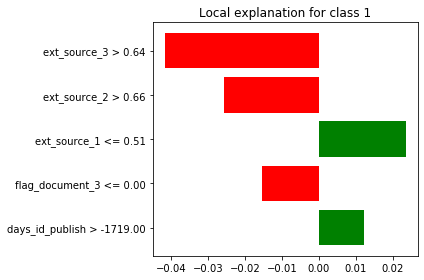

In [350]:
count = 0
for i in sorted_index_incorrect:
    
    print('Actual class: ', test_labels_array[i[0]])
    print('Predicted Class', tuned_lgbm_predictions[i[0]])
    # Get explanation
    exp = explainer.explain_instance((test_features[i[0]]), predict_fn, num_features=5)
    # Visualize the explanation 
    %matplotlib inline
    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.savefig("D:/Study/MS/NYU/Semesters/4. Spring 2022/Responsible Data Science/Project/Images/lime_{}.png".format(i[0]))
    plt.show()
    count += 1
    if count > 5:
        break

In [ ]:
exp.show_in_notebook(show_all=True)

In [ ]:
exp.as_list()